# <font color="red">Conditions Prediction with Naive Bayes BernoulliNB Classifier</font>

# Import Library

In [1]:
# Data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import json

# Preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import BaggingClassifier

import sys
sys.path.append('../../') # Uncomment this line if running locally
# sys.path.append('/kaggle/input/weatherdata') # Uncomment this line if running on Kaggle
from historyManagement import *

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Datasets Import

In [2]:
# Load the weather dataset for visibility prediction
weather_data = pd.read_csv('../../FinalDatasets/finalDataset.csv') # Uncomment this line if running locally
# weather_data = pd.read_csv('/kaggle/input/weatherdata/finalDataset.csv') # Uncomment this line if running on Kaggl
weather_data['DateTime'] = pd.to_datetime(weather_data['DateTime'])
weather_data.head()

DateTime  Year  Month  Day  Hour DaySegments  \
0 2023-01-01 00:00:00  2023      1    1     0  Late Night   
1 2023-01-01 01:00:00  2023      1    1     1  Late Night   
2 2023-01-01 02:00:00  2023      1    1     2  Late Night   
3 2023-01-01 03:00:00  2023      1    1     3  Late Night   
4 2023-01-01 04:00:00  2023      1    1     4  Late Night   

   DaySegments_Afternoon  DaySegments_Early Morning  DaySegments_Evening  \
0                      0                          0                    0   
1                      0                          0                    0   
2                      0                          0                    0   
3                      0                          0                    0   
4                      0                          0                    0   

   DaySegments_Late Night  ...  WindDir  SeaLevelPressure  CloudCover  \
0                       1  ...     0.49           1018.68        0.03   
1                       1  ...     0.54           1018.03        0.11   
2                       1  ...    30.51           1017.56        0.03   
3                       1  ...    49.23           1018.05        0.00   
4                       1  ...    49.90           1018.00       86.17   

   UVIndex  SevereRisk  Visibility  SolarRadiation SolarEnergy  \
0      0.0        10.0        2.76             0.0         0.0   
1      0.0        10.0        1.75             0.0         0.0   
2      0.0        10.0        1.75             0.0         0.0   
3      0.0        10.0        2.28             0.0         0.0   
4      0.0        10.0        1.27             0.0         0.0   

         Conditions         Icon  
0             Clear  clear-night  
1             Clear  clear-night  
2             Clear  clear-night  
3             Clear  clear-night  
4  Partially cloudy          fog  

[5 rows x 36 columns]

In [3]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

In [4]:
weather_data.describe()

DateTime          Year         Month           Day  \
count                14616  14616.000000  14616.000000  14616.000000   
mean   2023-11-01 11:30:00   2023.400657      5.720854     15.735632   
min    2023-01-01 00:00:00   2023.000000      1.000000      1.000000   
25%    2023-06-02 05:45:00   2023.000000      3.000000      8.000000   
50%    2023-11-01 11:30:00   2023.000000      6.000000     16.000000   
75%    2024-04-01 17:15:00   2024.000000      8.000000     23.000000   
max    2024-08-31 23:00:00   2024.000000     12.000000     31.000000   
std                    NaN      0.490048      3.195073      8.803610   

               Hour  DaySegments_Afternoon  DaySegments_Early Morning  \
count  14616.000000           14616.000000               14616.000000   
mean      11.500000               0.131294                   0.060550   
min        0.000000               0.000000                   0.000000   
25%        5.750000               0.000000                   0.000000   
50%       11.500000               0.000000                   0.000000   
75%       17.250000               0.000000                   0.000000   
max       23.000000               1.000000                   1.000000   
std        6.922423               0.337734                   0.238511   

       DaySegments_Evening  DaySegments_Late Night  DaySegments_Midday  ...  \
count         14616.000000            14616.000000        14616.000000  ...   
mean              0.098043                0.249726            0.116585  ...   
min               0.000000                0.000000            0.000000  ...   
25%               0.000000                0.000000            0.000000  ...   
50%               0.000000                0.000000            0.000000  ...   
75%               0.000000                0.000000            0.000000  ...   
max               1.000000                1.000000            1.000000  ...   
std               0.297383                0.432869            0.320936  ...   

           Windgust     WindSpeed       WindDir  SeaLevelPressure  \
count  14616.000000  14616.000000  14616.000000      14616.000000   
mean      17.068560      8.090783    159.739178       1008.265012   
min        0.660000      0.000000      0.000000        982.420000   
25%        9.170000      2.870000     80.965000       1003.277500   
50%       14.645000      7.670000    163.790000       1007.970000   
75%       23.410000     11.750000    241.402500       1013.400000   
max       84.120000     71.970000    360.000000       1022.060000   
std       10.195911      6.250203    104.422027          6.010683   

         CloudCover       UVIndex    SevereRisk    Visibility  SolarRadiation  \
count  14616.000000  14616.000000  14616.000000  14616.000000    14616.000000   
mean      53.579923      2.263555     16.504787      4.368134      227.640683   
min        0.000000      0.000000      3.000000      0.000000        0.000000   
25%       26.670000      0.000000     10.000000      3.990000        0.000000   
50%       51.540000      0.000000     10.000000      4.650000       10.665000   
75%       87.790000      4.740000     12.580000      4.650000      459.745000   
max      100.000000     10.000000     97.740000     24.100000     1026.650000   
std       35.166637      3.083074     15.031827      1.376994      307.219387   

        SolarEnergy  
count  14616.000000  
mean       0.819217  
min        0.000000  
25%        0.000000  
50%        0.010000  
75%        1.660000  
max        3.700000  
std        1.106444  

[8 rows x 32 columns]

# Data Split

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_idx, test_idx in sss.split(weather_data, weather_data['Conditions']):
    weather_data_train = weather_data.iloc[train_idx]
    weather_data_test = weather_data.iloc[test_idx]

In [6]:
# Show the count of each unique class in Conditions
class_counts = weather_data['Conditions'].value_counts().reset_index()
class_counts.columns = ['Conditions', 'Count']

print("Distribution of data based on Conditions:")
print(class_counts)

Distribution of data based on Conditions:
               Conditions  Count
0        Partially cloudy   7785
1                   Clear   3316
2  Rain, Partially cloudy   2118
3          Rain, Overcast    746
4                Overcast    629
5                    Rain     22


In [7]:
print("Distribution of Conditions in Training Set:")
print(weather_data_train['Conditions'].value_counts())

print("\nDistribution of Conditions in Test Set:")
print(weather_data_test['Conditions'].value_counts())

Distribution of Conditions in Training Set:
Conditions
Partially cloudy          6227
Clear                     2653
Rain, Partially cloudy    1694
Rain, Overcast             597
Overcast                   503
Rain                        18
Name: count, dtype: int64

Distribution of Conditions in Test Set:
Conditions
Partially cloudy          1558
Clear                      663
Rain, Partially cloudy     424
Rain, Overcast             149
Overcast                   126
Rain                         4
Name: count, dtype: int64


# Some Reused Parameters

In [8]:
grid_param = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
    'binarize': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

In [9]:
number_of_model_for_randomized_grid = 100
model_name_for_saving = "Naive Bayes BernoulliNB"
target_name_for_saving = "Conditions"
number_of_model_for_bagging = 100

# All Features

In [10]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon']) # Target variable
y_train = weather_data_train['Conditions']

In [11]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon']) # Target variable
y_test = weather_data_test['Conditions']

In [12]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [13]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2924
y_test:  2924


## MinMax Scaler

In [14]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [15]:
X_train

array([[0.81818182, 0.46666667, 0.69565217, ..., 0.4906    , 0.319     ,
        0.08950813],
       [0.27272727, 0.16666667, 0.86956522, ..., 0.5161    , 0.        ,
        0.68439941],
       [1.        , 0.3       , 0.        , ..., 0.3604    , 0.        ,
        0.07388643],
       ...,
       [0.27272727, 0.83333333, 0.        , ..., 0.2311    , 0.        ,
        0.07388643],
       [0.18181818, 0.53333333, 0.34782609, ..., 0.8811    , 0.197     ,
        0.0204771 ],
       [0.18181818, 0.8       , 0.65217391, ..., 0.8155    , 0.542     ,
        0.07388643]], shape=(11692, 27))

In [16]:
X_test

array([[0.18181818, 0.4       , 0.52173913, ..., 0.2298    , 0.9       ,
        0.07388643],
       [0.72727273, 0.06666667, 1.        , ..., 0.8872    , 0.        ,
        0.08074731],
       [0.45454545, 0.56666667, 0.73913043, ..., 0.8894    , 0.206     ,
        0.58465273],
       ...,
       [0.27272727, 0.76666667, 0.82608696, ..., 0.8816    , 0.        ,
        0.06195905],
       [0.72727273, 0.43333333, 0.86956522, ..., 0.8825    , 0.        ,
        0.09436352],
       [0.27272727, 0.66666667, 0.26086957, ..., 0.4901    , 0.        ,
        0.99324467]], shape=(2924, 27))

### Default Parameters

In [17]:
training_model = BernoulliNB()
training_model

BernoulliNB()

In [18]:
%%time
training_model.fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 20.4 ms


BernoulliNB()

In [19]:
y_pred = training_model.predict(X_test)
y_pred

array(['Partially cloudy', 'Rain, Partially cloudy',
       'Rain, Partially cloudy', ..., 'Partially cloudy',
       'Partially cloudy', 'Partially cloudy'],
      shape=(2924,), dtype='<U22')

In [20]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [21]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [22]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.7014
Precision: 0.6994
Recall:    0.7014
F1-Score:  0.6768


In [23]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.74      0.67      0.70       663
              Overcast       0.00      0.00      0.00       126
      Partially cloudy       0.80      0.76      0.78      1558
                  Rain       0.67      0.50      0.57         4
        Rain, Overcast       0.60      0.06      0.11       149
Rain, Partially cloudy       0.50      0.99      0.66       424

              accuracy                           0.70      2924
             macro avg       0.55      0.50      0.47      2924
          weighted avg       0.70      0.70      0.68      2924



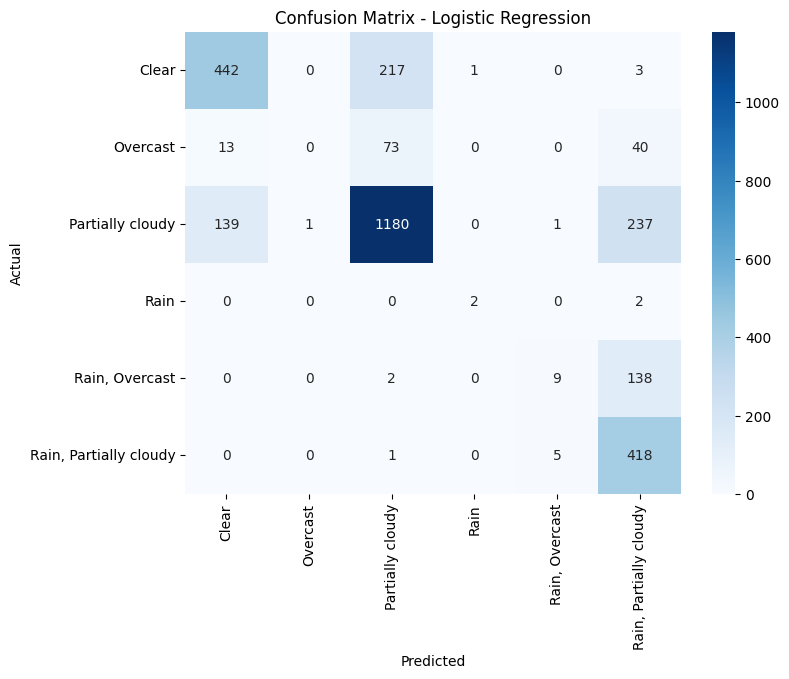

In [24]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [25]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [26]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [27]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9117
Overcast : 0.6694
Partially cloudy : 0.8397
Rain     : 0.9166
Rain, Overcast : 0.8863
Rain, Partially cloudy : 0.9183
Micro-avg : 0.9358


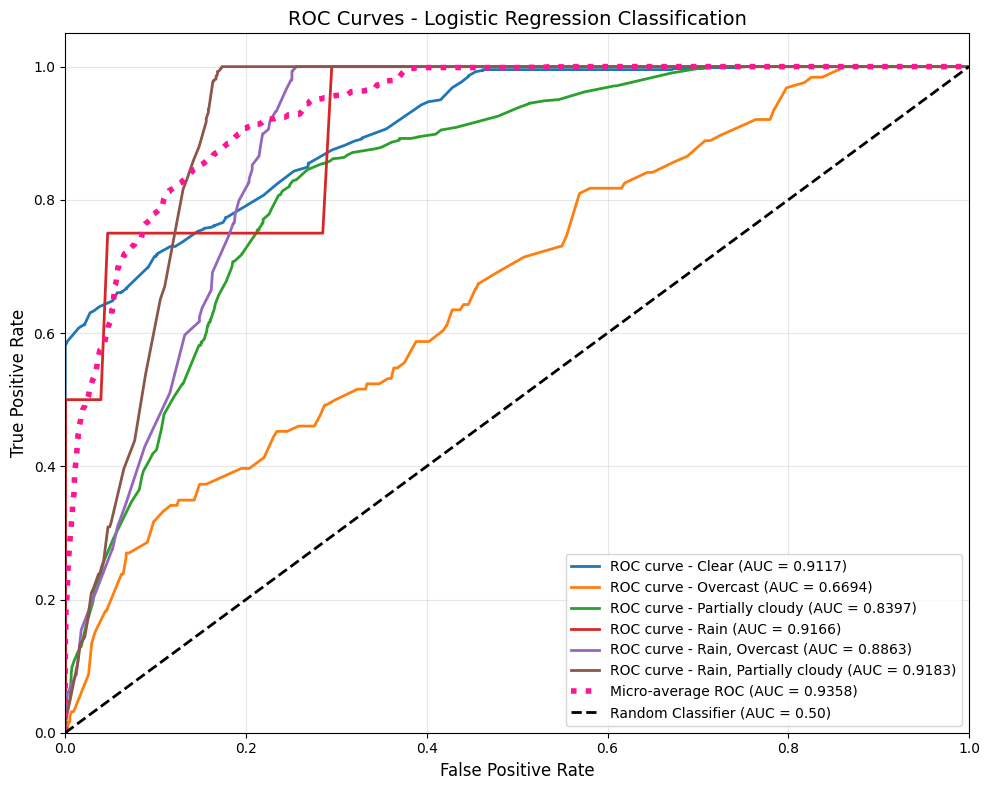

In [28]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.8626
One-vs-One (Weighted)  : 0.8582
Micro-average          : 0.9358


In [30]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.701436, F1: 0.676767, AUC (micro-avg): 0.935829
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [31]:
grid_search = RandomizedSearchCV(
    BernoulliNB(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=BernoulliNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0, 1.1, 1.2,
                                                  1.3, 1.4, 1.5],
                                        'binarize': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                     0.5]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [32]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
CPU times: total: 1.38 s
Wall time: 9.22 s


RandomizedSearchCV(cv=5, estimator=BernoulliNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0, 1.1, 1.2,
                                                  1.3, 1.4, 1.5],
                                        'binarize': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                     0.5]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [33]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'binarize': 0.2, 'alpha': 1.1}
Best Cross-Validation Score: 0.8573829972548062


In [34]:
y_pred_grid = best_grid_model.predict(X_test)

In [35]:
y_pred_grid

array(['Partially cloudy', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      shape=(2924,), dtype='<U22')

In [36]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [37]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [38]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.8875
Precision: 0.8430
Recall:    0.8875
F1-Score:  0.8593


In [39]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.96      0.95      0.95       663
              Overcast       0.00      0.00      0.00       126
      Partially cloudy       0.91      0.98      0.94      1558
                  Rain       0.60      0.75      0.67         4
        Rain, Overcast       0.59      0.23      0.34       149
Rain, Partially cloudy       0.78      0.94      0.85       424

              accuracy                           0.89      2924
             macro avg       0.64      0.64      0.62      2924
          weighted avg       0.84      0.89      0.86      2924



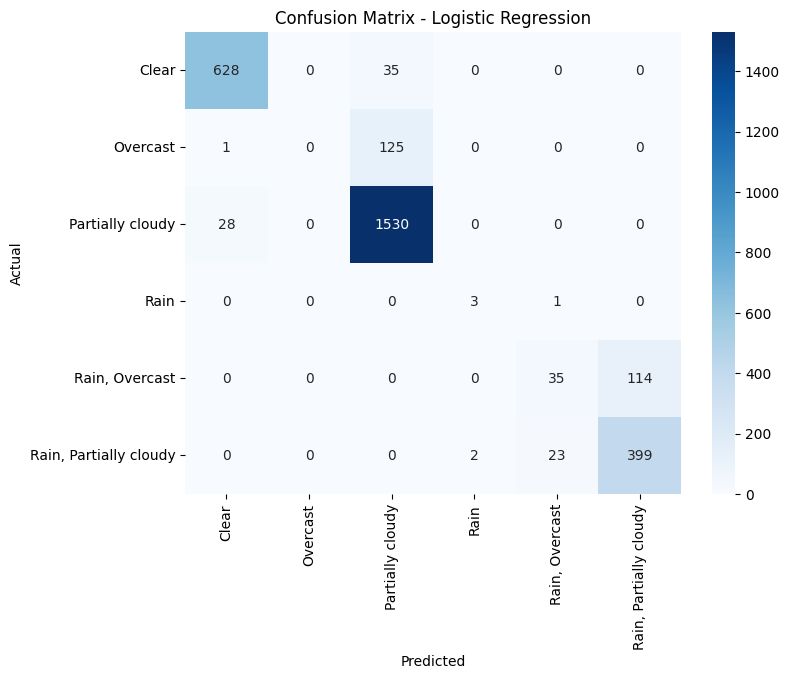

In [40]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [41]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [42]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [43]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9928
Overcast : 0.8259
Partially cloudy : 0.9607
Rain     : 0.9747
Rain, Overcast : 0.9471
Rain, Partially cloudy : 0.9796
Micro-avg : 0.9865


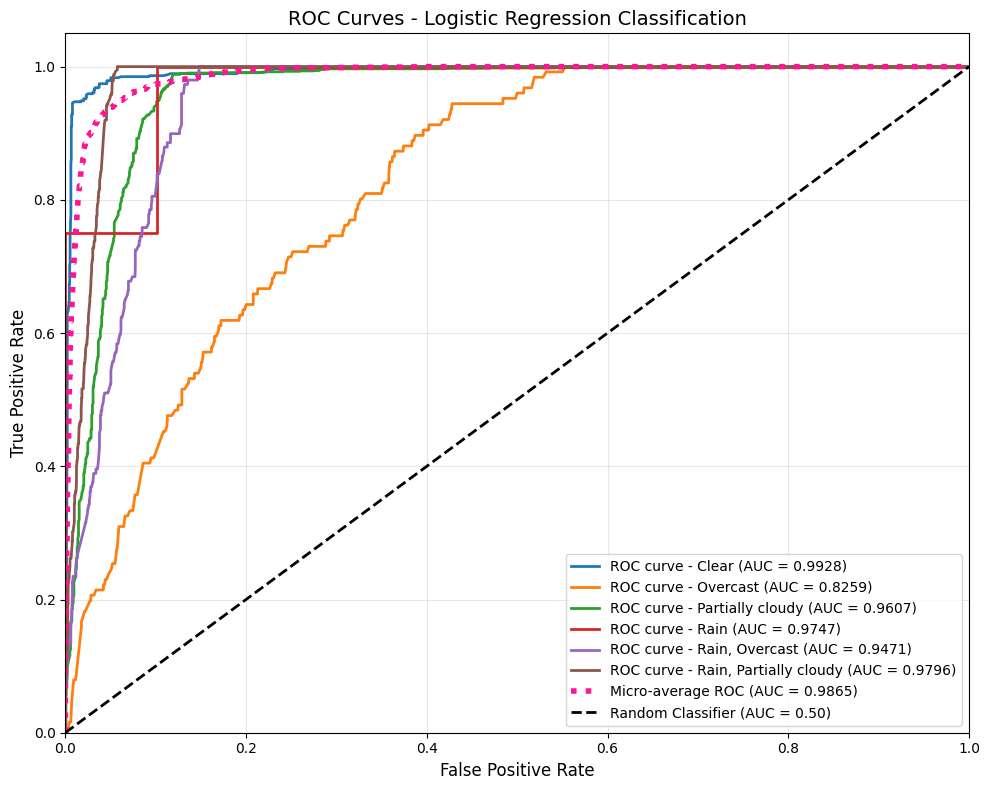

In [44]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [45]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9642
One-vs-One (Weighted)  : 0.9433
Micro-average          : 0.9865


In [46]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.887483, F1: 0.859298, AUC (micro-avg): 0.986459
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [47]:
base_model = BernoulliNB()
base_model

BernoulliNB()

In [48]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=BernoulliNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [49]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


CPU times: total: 15.6 ms
Wall time: 545 ms


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


BaggingClassifier(bootstrap_features=True, estimator=BernoulliNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [50]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [51]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [52]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.7059
Precision: 0.6741
Recall:    0.7059
F1-Score:  0.6767


In [53]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.77      0.66      0.71       663
              Overcast       0.00      0.00      0.00       126
      Partially cloudy       0.80      0.77      0.79      1558
                  Rain       0.67      0.50      0.57         4
        Rain, Overcast       0.00      0.00      0.00       149
Rain, Partially cloudy       0.50      1.00      0.66       424

              accuracy                           0.71      2924
             macro avg       0.46      0.49      0.46      2924
          weighted avg       0.67      0.71      0.68      2924



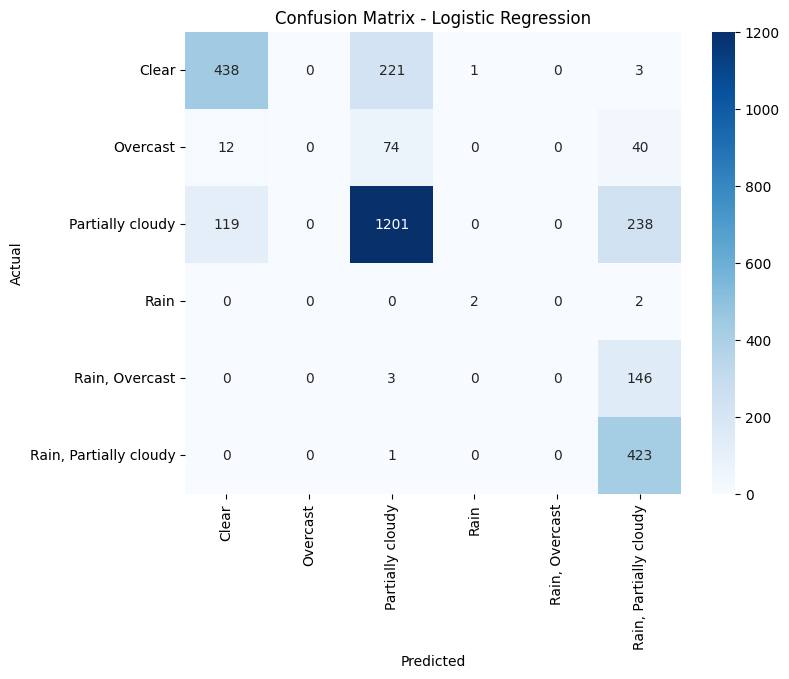

In [54]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [55]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [56]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [57]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9116
Overcast : 0.6841
Partially cloudy : 0.8181
Rain     : 0.8377
Rain, Overcast : 0.8854
Rain, Partially cloudy : 0.9212
Micro-avg : 0.9398


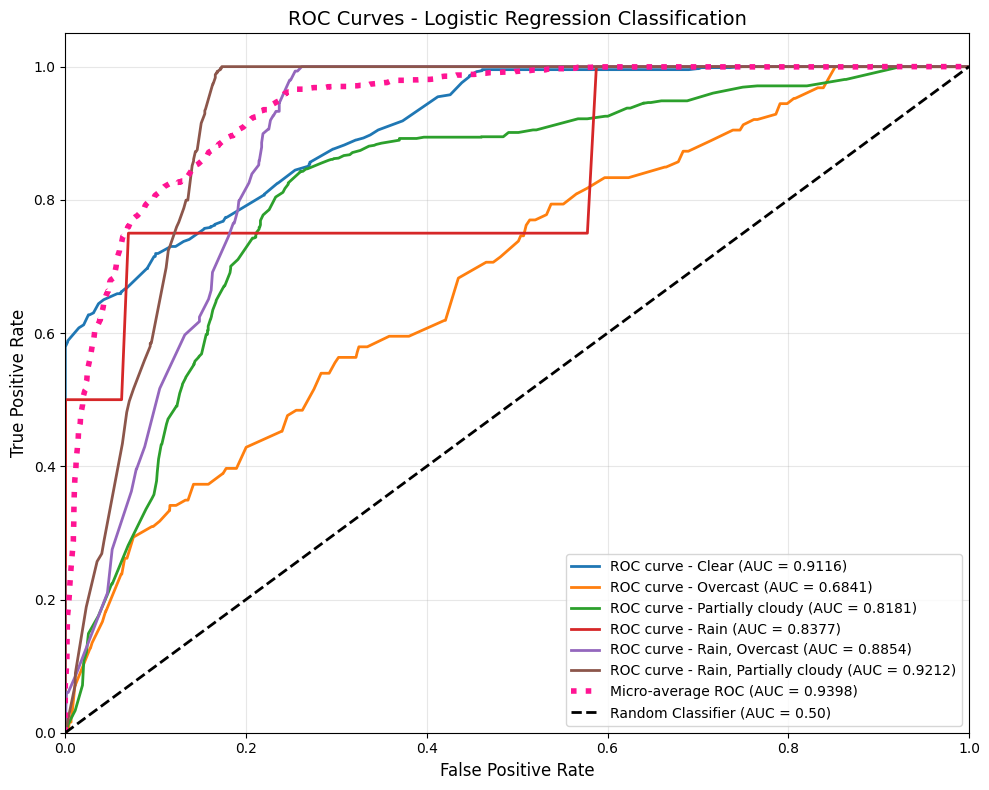

In [58]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [59]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.8519
One-vs-One (Weighted)  : 0.8486
Micro-average          : 0.9398


In [60]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.705882, F1: 0.676676, AUC (micro-avg): 0.939757
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


## Standard Scaler

In [61]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [62]:
X_train

array([[ 1.34459066, -0.08798128,  0.64443839, ..., -0.12811963,
         0.28861286, -0.33504216],
       [-0.53250082, -1.10860676,  1.22392493, ..., -0.05563671,
        -0.74169989,  3.44763404],
       [ 1.97028782, -0.65499543, -1.67350776, ..., -0.4982089 ,
        -0.74169989, -0.43437432],
       ...,
       [-0.53250082,  1.15944987, -1.67350776, ..., -0.86573995,
        -0.74169989, -0.43437432],
       [-0.8453494 ,  0.13882439, -0.51453468, ...,  0.98186394,
        -0.10542524, -0.77398294],
       [-0.8453494 ,  1.04604704,  0.49956676, ...,  0.79539807,
         1.00886284, -0.43437432]], shape=(11692, 27))

In [63]:
X_test

array([[-0.8453494 , -0.31478694,  0.06495186, ..., -0.86943516,
         2.16513859, -0.43437432],
       [ 1.03174208, -1.44881525,  1.65853984, ...,  0.99920299,
        -0.74169989, -0.39074871],
       [ 0.09319634,  0.25222722,  0.78931003, ...,  1.00545642,
        -0.07635686,  2.81338475],
       ...,
       [-0.53250082,  0.9326442 ,  1.0790533 , ...,  0.98328517,
        -0.74169989, -0.51021577],
       [ 1.03174208, -0.20138411,  1.22392493, ...,  0.98584339,
        -0.74169989, -0.30416865],
       [-0.53250082,  0.59243571, -0.80427795, ..., -0.12954086,
        -0.74169989,  5.41145777]], shape=(2924, 27))

### Default Parameters

In [64]:
training_model = BernoulliNB()
training_model

BernoulliNB()

In [65]:
%%time
training_model.fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 24.8 ms


BernoulliNB()

In [66]:
y_pred = training_model.predict(X_test)
y_pred

array(['Clear', 'Partially cloudy', 'Overcast', ..., 'Partially cloudy',
       'Partially cloudy', 'Partially cloudy'],
      shape=(2924,), dtype='<U22')

In [67]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [68]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [69]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.6761
Precision: 0.7258
Recall:    0.6761
F1-Score:  0.6901


In [70]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.58      0.76      0.66       663
              Overcast       0.24      0.51      0.33       126
      Partially cloudy       0.82      0.64      0.72      1558
                  Rain       0.12      0.75      0.21         4
        Rain, Overcast       0.51      0.56      0.54       149
Rain, Partially cloudy       0.84      0.76      0.80       424

              accuracy                           0.68      2924
             macro avg       0.52      0.66      0.54      2924
          weighted avg       0.73      0.68      0.69      2924



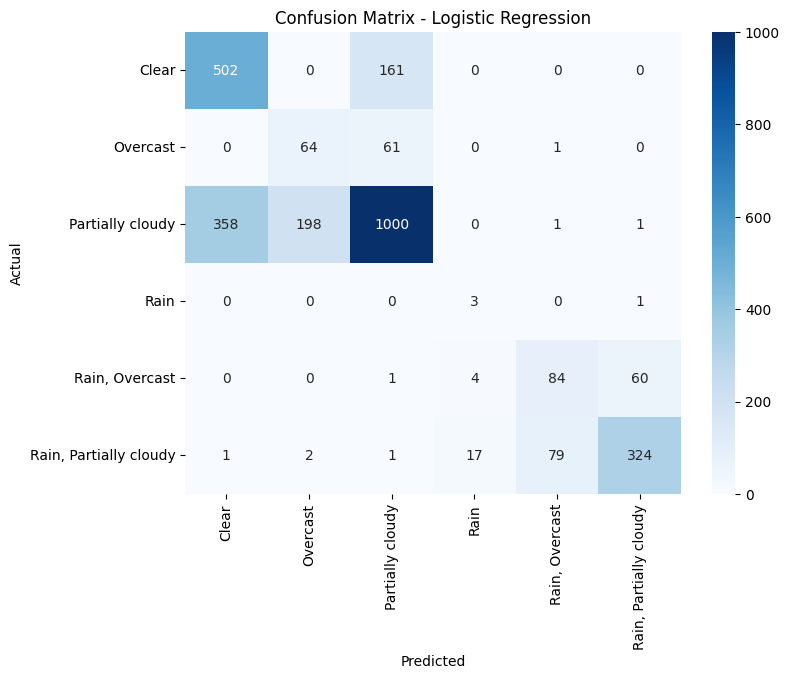

In [71]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [72]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [73]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [74]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.8934
Overcast : 0.9023
Partially cloudy : 0.8480
Rain     : 0.8446
Rain, Overcast : 0.9650
Rain, Partially cloudy : 0.9834
Micro-avg : 0.9459


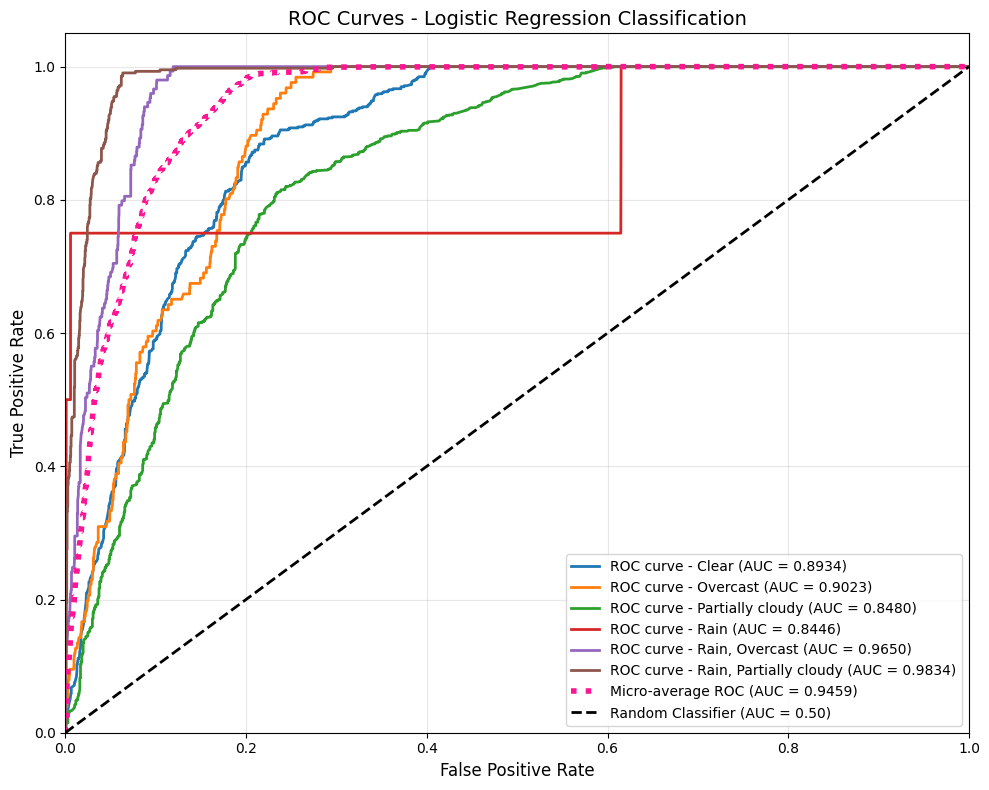

In [75]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [76]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.8862
One-vs-One (Weighted)  : 0.9052
Micro-average          : 0.9459


In [77]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.676129, F1: 0.690139, AUC (micro-avg): 0.945852
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [78]:
grid_search = RandomizedSearchCV(
    BernoulliNB(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=BernoulliNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0, 1.1, 1.2,
                                                  1.3, 1.4, 1.5],
                                        'binarize': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                     0.5]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [79]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
CPU times: total: 656 ms
Wall time: 6.36 s


RandomizedSearchCV(cv=5, estimator=BernoulliNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0, 1.1, 1.2,
                                                  1.3, 1.4, 1.5],
                                        'binarize': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                     0.5]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [80]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'binarize': 0.3, 'alpha': 0.1}
Best Cross-Validation Score: 0.6973120528125445


In [81]:
y_pred_grid = best_grid_model.predict(X_test)

In [82]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [83]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.6840
Precision: 0.7314
Recall:    0.6840
F1-Score:  0.6949


In [84]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.56      0.79      0.66       663
              Overcast       0.29      0.48      0.36       126
      Partially cloudy       0.83      0.65      0.73      1558
                  Rain       0.18      0.50      0.27         4
        Rain, Overcast       0.48      0.65      0.55       149
Rain, Partially cloudy       0.85      0.73      0.79       424

              accuracy                           0.68      2924
             macro avg       0.53      0.63      0.56      2924
          weighted avg       0.73      0.68      0.69      2924



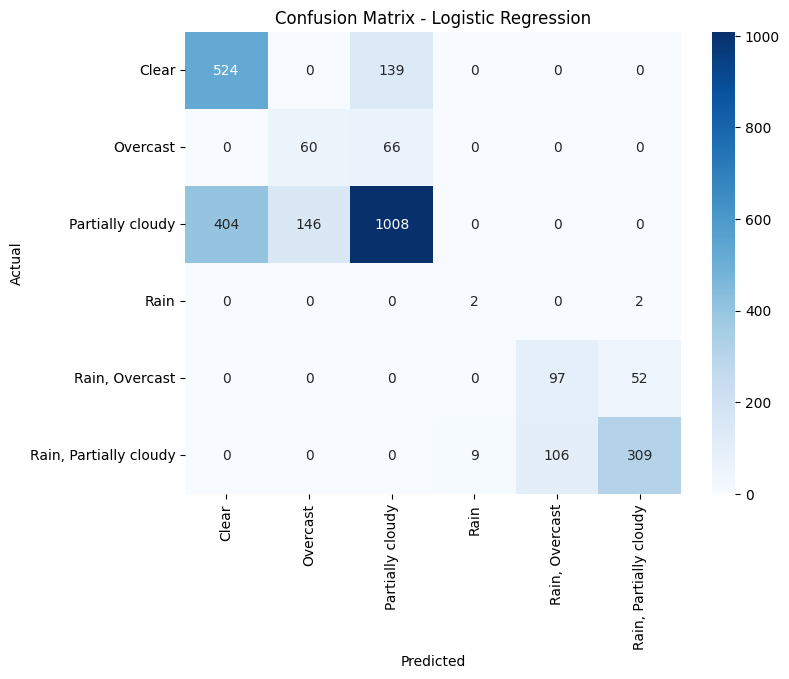

In [85]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [86]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [87]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [88]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.8893
Overcast : 0.9189
Partially cloudy : 0.8515
Rain     : 0.8110
Rain, Overcast : 0.9702
Rain, Partially cloudy : 0.9865
Micro-avg : 0.9496


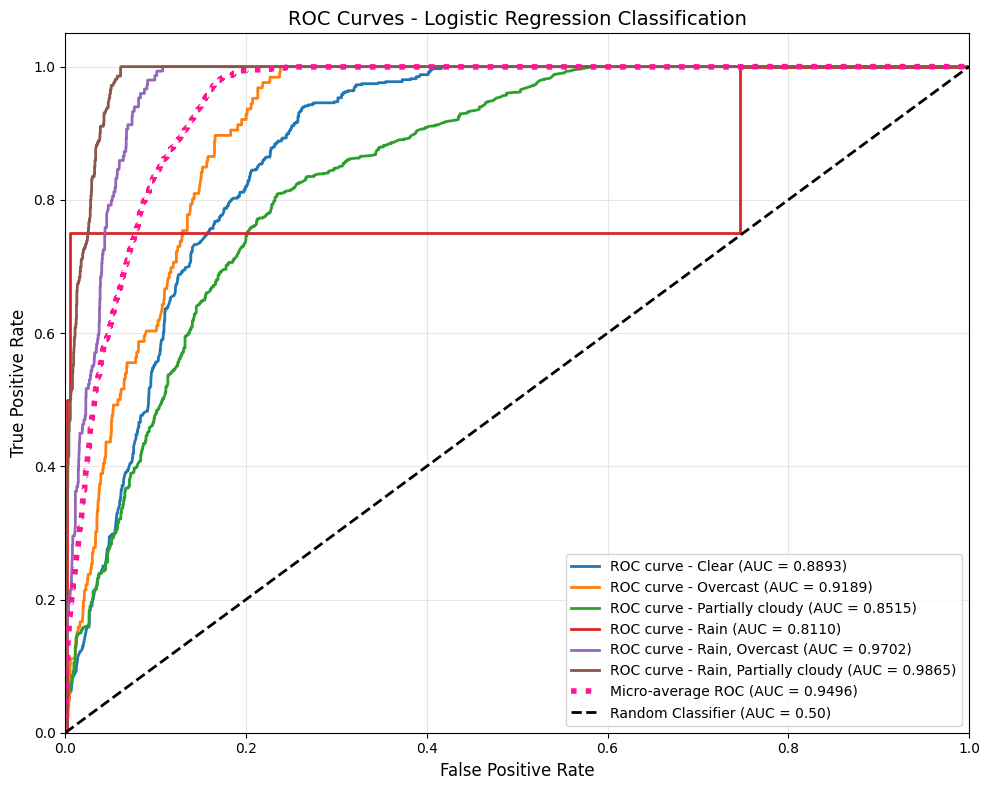

In [89]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [90]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.8885
One-vs-One (Weighted)  : 0.9054
Micro-average          : 0.9496


In [91]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.683995, F1: 0.694904, AUC (micro-avg): 0.949640
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [92]:
base_model = BernoulliNB()
base_model

BernoulliNB()

In [93]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=BernoulliNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [94]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s


CPU times: total: 62.5 ms
Wall time: 383 ms


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


BaggingClassifier(bootstrap_features=True, estimator=BernoulliNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [95]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [96]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [97]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.7045
Precision: 0.7218
Recall:    0.7045
F1-Score:  0.7085


In [98]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.58      0.75      0.66       663
              Overcast       0.27      0.29      0.28       126
      Partially cloudy       0.81      0.70      0.75      1558
                  Rain       0.20      0.50      0.29         4
        Rain, Overcast       0.56      0.50      0.53       149
Rain, Partially cloudy       0.82      0.83      0.82       424

              accuracy                           0.70      2924
             macro avg       0.54      0.60      0.55      2924
          weighted avg       0.72      0.70      0.71      2924



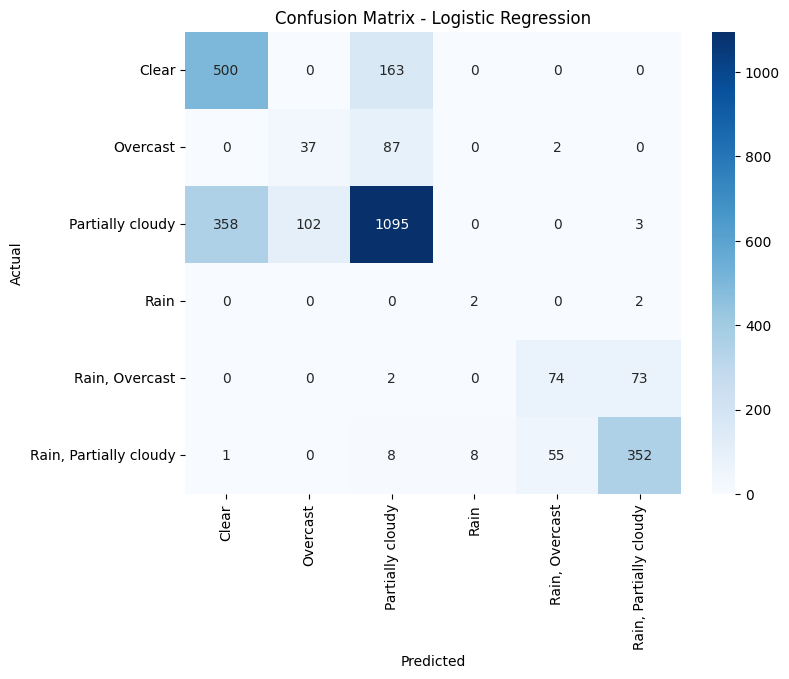

In [99]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [100]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [101]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [102]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.8864
Overcast : 0.8978
Partially cloudy : 0.8201
Rain     : 0.8735
Rain, Overcast : 0.9607
Rain, Partially cloudy : 0.9785
Micro-avg : 0.9375


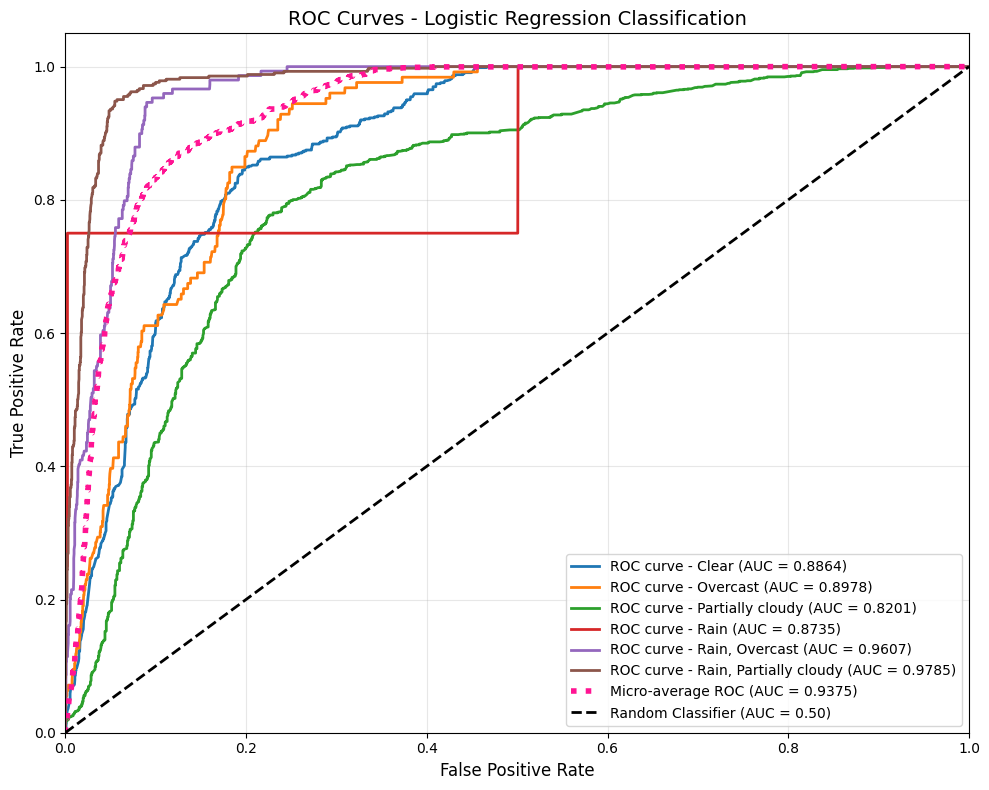

In [103]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [104]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.8687
One-vs-One (Weighted)  : 0.8925
Micro-average          : 0.9375


In [105]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.704514, F1: 0.708458, AUC (micro-avg): 0.937485
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


## Robust Scaler

In [106]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [107]:
X_train

array([[ 1.00000000e+00, -6.66666667e-02,  3.33333333e-01, ...,
        -4.07728836e-02,  6.55030801e-01,  5.73643411e-01],
       [-2.00000000e-01, -6.66666667e-01,  6.66666667e-01, ...,
         9.82479122e-04,  0.00000000e+00,  2.24186047e+01],
       [ 1.40000000e+00, -4.00000000e-01, -1.00000000e+00, ...,
        -2.53970853e-01,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.00000000e-01,  6.66666667e-01, -1.00000000e+00, ...,
        -4.65695104e-01,  0.00000000e+00,  0.00000000e+00],
       [-4.00000000e-01,  6.66666667e-02, -3.33333333e-01, ...,
         5.98657279e-01,  4.04517454e-01, -1.96124031e+00],
       [-4.00000000e-01,  6.00000000e-01,  2.50000000e-01, ...,
         4.91239561e-01,  1.11293634e+00,  0.00000000e+00]],
      shape=(11692, 27))

In [108]:
X_test

array([[-0.4       , -0.2       ,  0.        , ..., -0.46782381,
         1.84804928,  0.        ],
       [ 0.8       , -0.86666667,  0.91666667, ...,  0.60864582,
         0.        ,  0.25193798],
       [ 0.2       ,  0.13333333,  0.41666667, ...,  0.61224824,
         0.42299795, 18.75581395],
       ...,
       [-0.2       ,  0.53333333,  0.58333333, ...,  0.59947601,
         0.        , -0.4379845 ],
       [ 0.8       , -0.13333333,  0.66666667, ...,  0.60094973,
         0.        ,  0.75193798],
       [-0.2       ,  0.33333333, -0.5       , ..., -0.04159162,
         0.        , 33.75968992]], shape=(2924, 27))

### Default Parameters

In [109]:
training_model = BernoulliNB()
training_model

BernoulliNB()

In [110]:
%%time
training_model.fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 20.2 ms


BernoulliNB()

In [111]:
y_pred = training_model.predict(X_test)
y_pred

array(['Clear', 'Rain, Partially cloudy', 'Rain, Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      shape=(2924,), dtype='<U22')

In [112]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [113]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [114]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.6259
Precision: 0.6626
Recall:    0.6259
F1-Score:  0.6296


In [115]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.59      0.79      0.68       663
              Overcast       0.25      0.25      0.25       126
      Partially cloudy       0.79      0.57      0.66      1558
                  Rain       0.12      0.75      0.20         4
        Rain, Overcast       0.37      0.48      0.42       149
Rain, Partially cloudy       0.55      0.73      0.63       424

              accuracy                           0.63      2924
             macro avg       0.44      0.59      0.47      2924
          weighted avg       0.66      0.63      0.63      2924



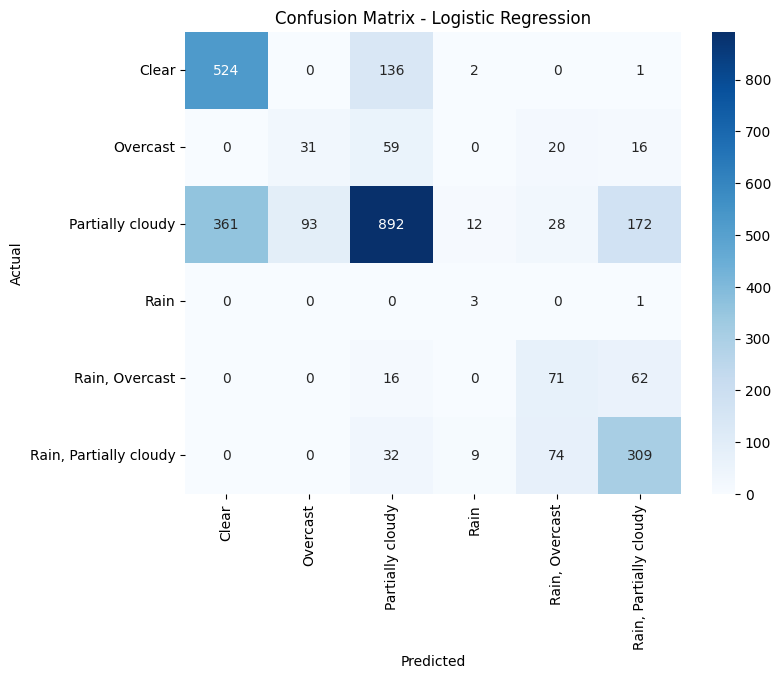

In [116]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [117]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [118]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [119]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9017
Overcast : 0.8463
Partially cloudy : 0.7663
Rain     : 0.8674
Rain, Overcast : 0.9291
Rain, Partially cloudy : 0.9302
Micro-avg : 0.9177


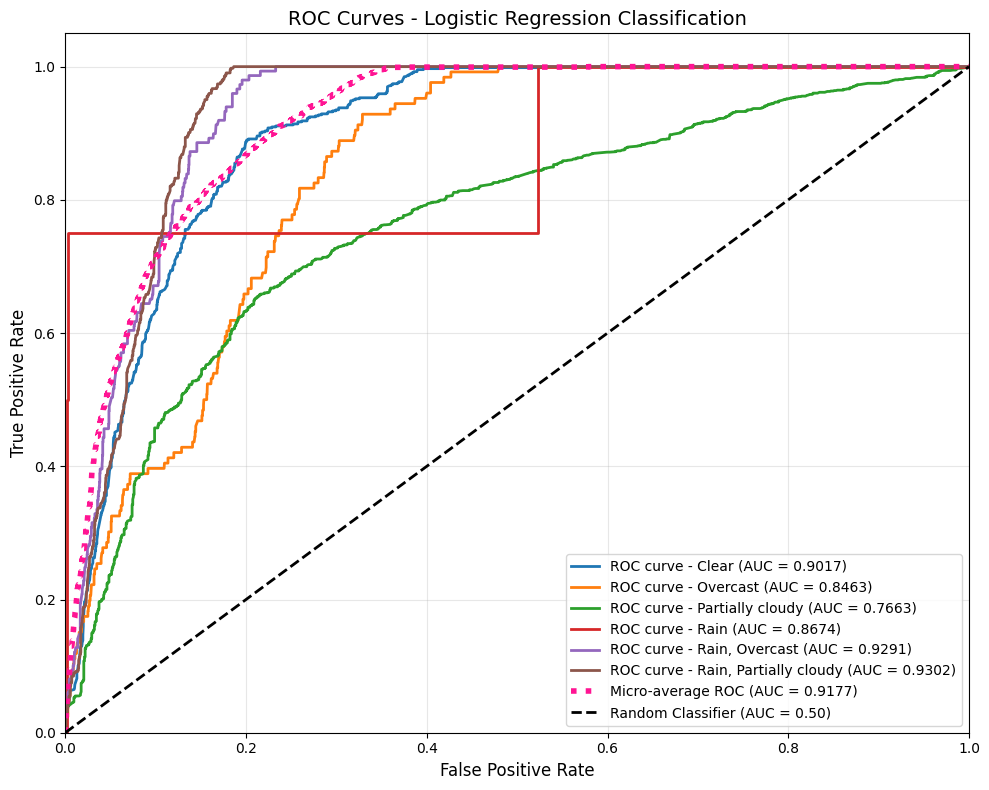

In [120]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [121]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.8327
One-vs-One (Weighted)  : 0.8586
Micro-average          : 0.9177


In [122]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.625855, F1: 0.629582, AUC (micro-avg): 0.917706
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [123]:
grid_search = RandomizedSearchCV(
    BernoulliNB(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=BernoulliNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0, 1.1, 1.2,
                                                  1.3, 1.4, 1.5],
                                        'binarize': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                     0.5]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [124]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
CPU times: total: 734 ms
Wall time: 6.43 s


RandomizedSearchCV(cv=5, estimator=BernoulliNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0, 1.1, 1.2,
                                                  1.3, 1.4, 1.5],
                                        'binarize': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                     0.5]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [125]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'binarize': 0.5, 'alpha': 1.4}
Best Cross-Validation Score: 0.6447776054322978


In [126]:
y_pred_grid = best_grid_model.predict(X_test)

In [127]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [128]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.6317
Precision: 0.6699
Recall:    0.6317
F1-Score:  0.6327


In [129]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.56      0.78      0.65       663
              Overcast       0.31      0.22      0.26       126
      Partially cloudy       0.80      0.57      0.66      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.40      0.70      0.51       149
Rain, Partially cloudy       0.58      0.74      0.65       424

              accuracy                           0.63      2924
             macro avg       0.44      0.50      0.46      2924
          weighted avg       0.67      0.63      0.63      2924



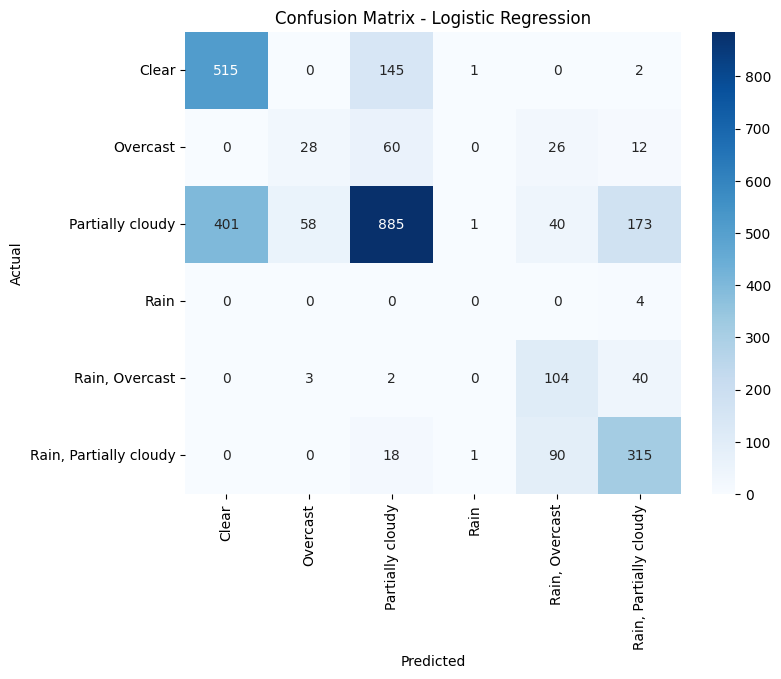

In [130]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [131]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [132]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [133]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.8787
Overcast : 0.8849
Partially cloudy : 0.7608
Rain     : 0.8952
Rain, Overcast : 0.9499
Rain, Partially cloudy : 0.9348
Micro-avg : 0.9222


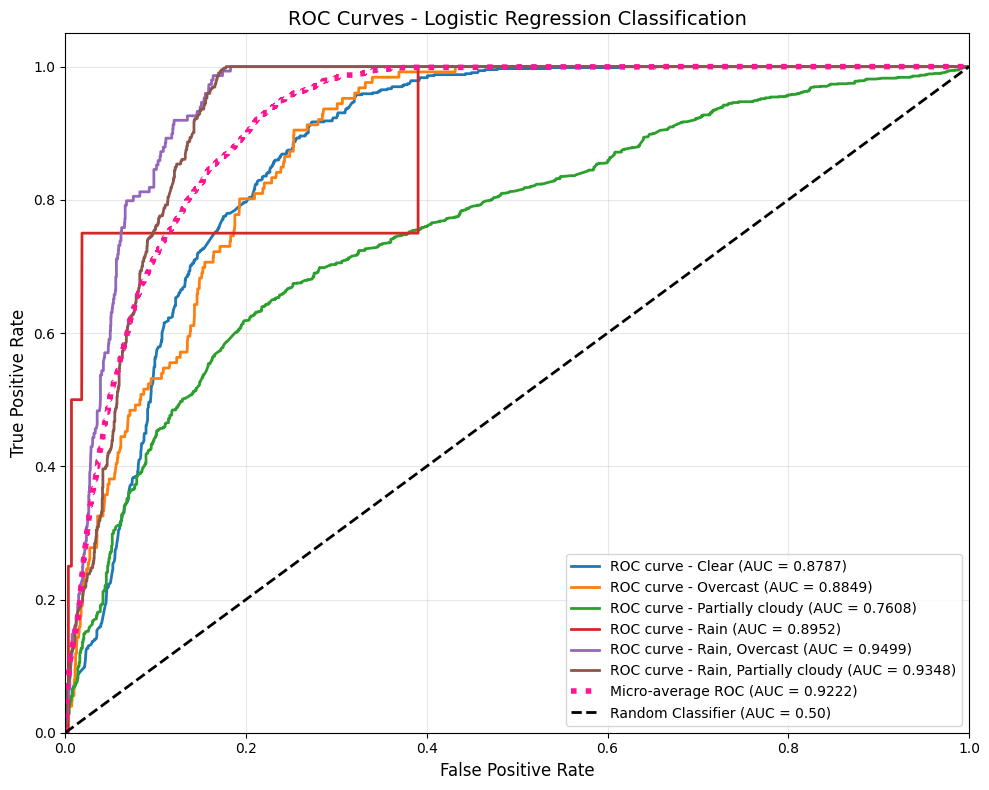

In [134]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [135]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.8279
One-vs-One (Weighted)  : 0.8661
Micro-average          : 0.9222


In [136]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.631669, F1: 0.632717, AUC (micro-avg): 0.922159
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [137]:
base_model = BernoulliNB()
base_model

BernoulliNB()

In [138]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=BernoulliNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [139]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s


CPU times: total: 31.2 ms
Wall time: 332 ms


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


BaggingClassifier(bootstrap_features=True, estimator=BernoulliNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [140]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [141]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [142]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.6430
Precision: 0.6613
Recall:    0.6430
F1-Score:  0.6389


In [143]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.59      0.80      0.68       663
              Overcast       0.31      0.10      0.15       126
      Partially cloudy       0.78      0.62      0.69      1558
                  Rain       0.21      0.75      0.33         4
        Rain, Overcast       0.37      0.43      0.40       149
Rain, Partially cloudy       0.54      0.73      0.63       424

              accuracy                           0.64      2924
             macro avg       0.47      0.57      0.48      2924
          weighted avg       0.66      0.64      0.64      2924



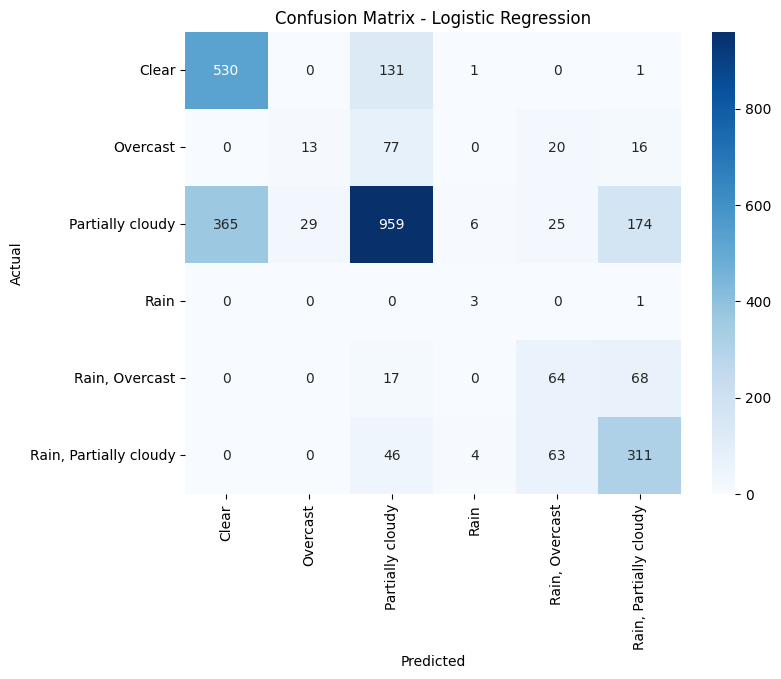

In [144]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [145]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [146]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [147]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.8959
Overcast : 0.8382
Partially cloudy : 0.7676
Rain     : 0.8574
Rain, Overcast : 0.9283
Rain, Partially cloudy : 0.9269
Micro-avg : 0.9134


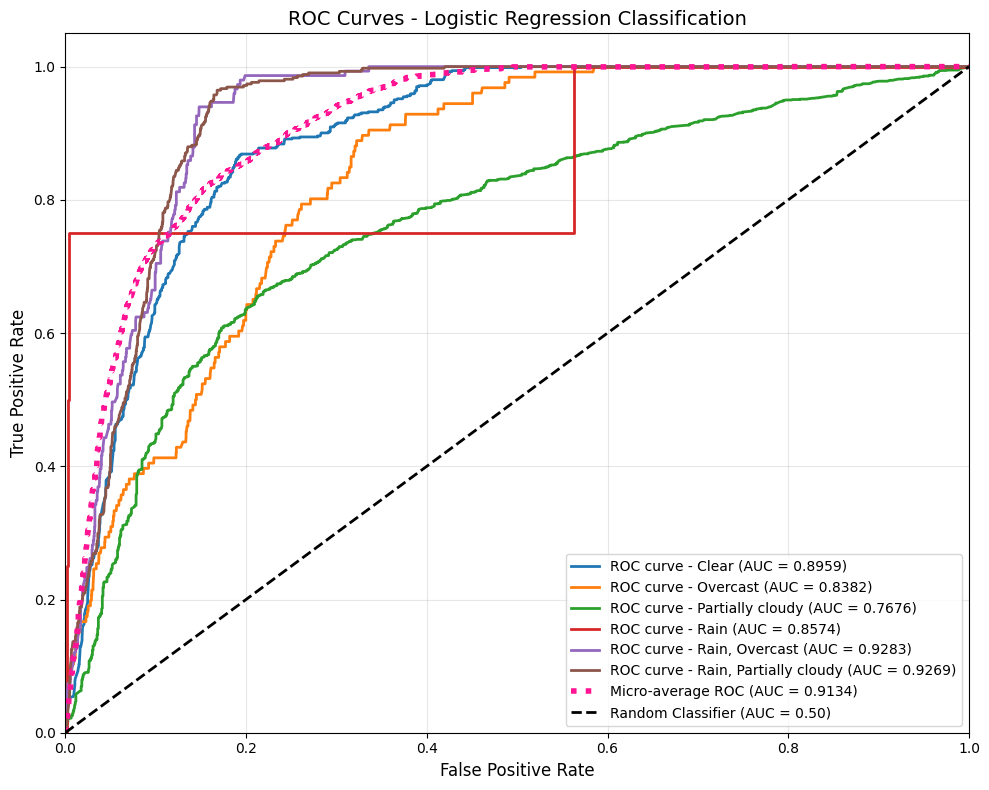

In [148]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [149]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.8312
One-vs-One (Weighted)  : 0.8525
Micro-average          : 0.9134


In [150]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.642955, F1: 0.638920, AUC (micro-avg): 0.913445
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


# Selected Features

In [151]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

## Run Again

In [152]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_train = weather_data_train['Conditions']

In [153]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_test = weather_data_test['Conditions']

In [154]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [155]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2924
y_test:  2924


### MinMax Scaler

In [156]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [157]:
X_train

array([[0.81818182, 0.69565217, 1.        , ..., 0.4906    , 0.319     ,
        0.08950813],
       [0.27272727, 0.86956522, 0.        , ..., 0.5161    , 0.        ,
        0.68439941],
       [1.        , 0.        , 0.        , ..., 0.3604    , 0.        ,
        0.07388643],
       ...,
       [0.27272727, 0.        , 0.        , ..., 0.2311    , 0.        ,
        0.07388643],
       [0.18181818, 0.34782609, 0.        , ..., 0.8811    , 0.197     ,
        0.0204771 ],
       [0.18181818, 0.65217391, 1.        , ..., 0.8155    , 0.542     ,
        0.07388643]], shape=(11692, 23))

In [158]:
X_test

array([[0.18181818, 0.52173913, 0.        , ..., 0.2298    , 0.9       ,
        0.07388643],
       [0.72727273, 1.        , 0.        , ..., 0.8872    , 0.        ,
        0.08074731],
       [0.45454545, 0.73913043, 1.        , ..., 0.8894    , 0.206     ,
        0.58465273],
       ...,
       [0.27272727, 0.82608696, 0.        , ..., 0.8816    , 0.        ,
        0.06195905],
       [0.72727273, 0.86956522, 0.        , ..., 0.8825    , 0.        ,
        0.09436352],
       [0.27272727, 0.26086957, 0.        , ..., 0.4901    , 0.        ,
        0.99324467]], shape=(2924, 23))

#### Default Parameters

In [159]:
training_model = BernoulliNB()
training_model

BernoulliNB()

In [160]:
%%time
training_model.fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 26.8 ms


BernoulliNB()

In [161]:
y_pred = training_model.predict(X_test)
y_pred

array(['Partially cloudy', 'Rain, Partially cloudy',
       'Rain, Partially cloudy', ..., 'Partially cloudy',
       'Partially cloudy', 'Partially cloudy'],
      shape=(2924,), dtype='<U22')

In [162]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [163]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [164]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.7011
Precision: 0.6694
Recall:    0.7011
F1-Score:  0.6722


In [165]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.75      0.67      0.70       663
              Overcast       0.00      0.00      0.00       126
      Partially cloudy       0.80      0.76      0.78      1558
                  Rain       0.67      0.50      0.57         4
        Rain, Overcast       0.00      0.00      0.00       149
Rain, Partially cloudy       0.50      1.00      0.66       424

              accuracy                           0.70      2924
             macro avg       0.45      0.49      0.45      2924
          weighted avg       0.67      0.70      0.67      2924



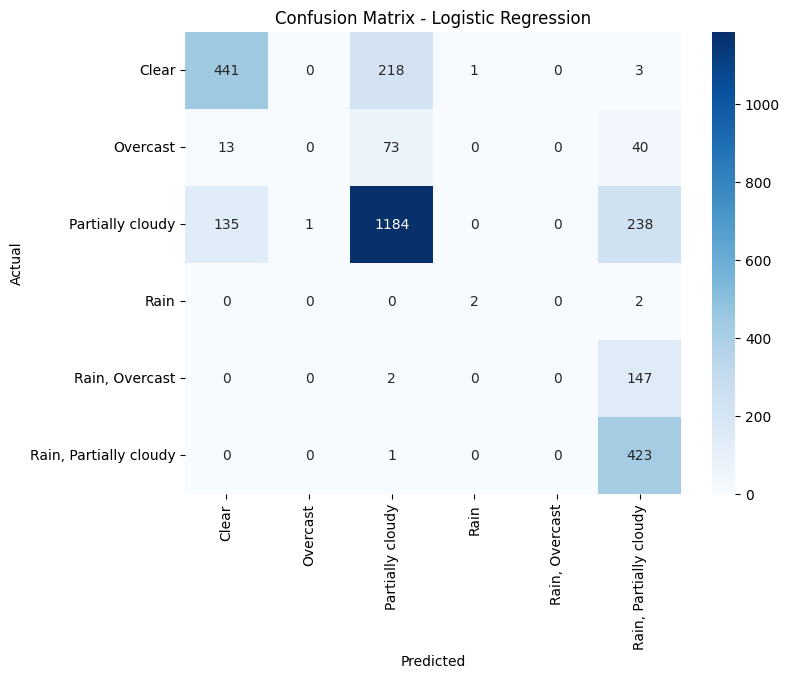

In [166]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [167]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [168]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [169]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9111
Overcast : 0.6708
Partially cloudy : 0.8390
Rain     : 0.9172
Rain, Overcast : 0.8837
Rain, Partially cloudy : 0.9177
Micro-avg : 0.9355


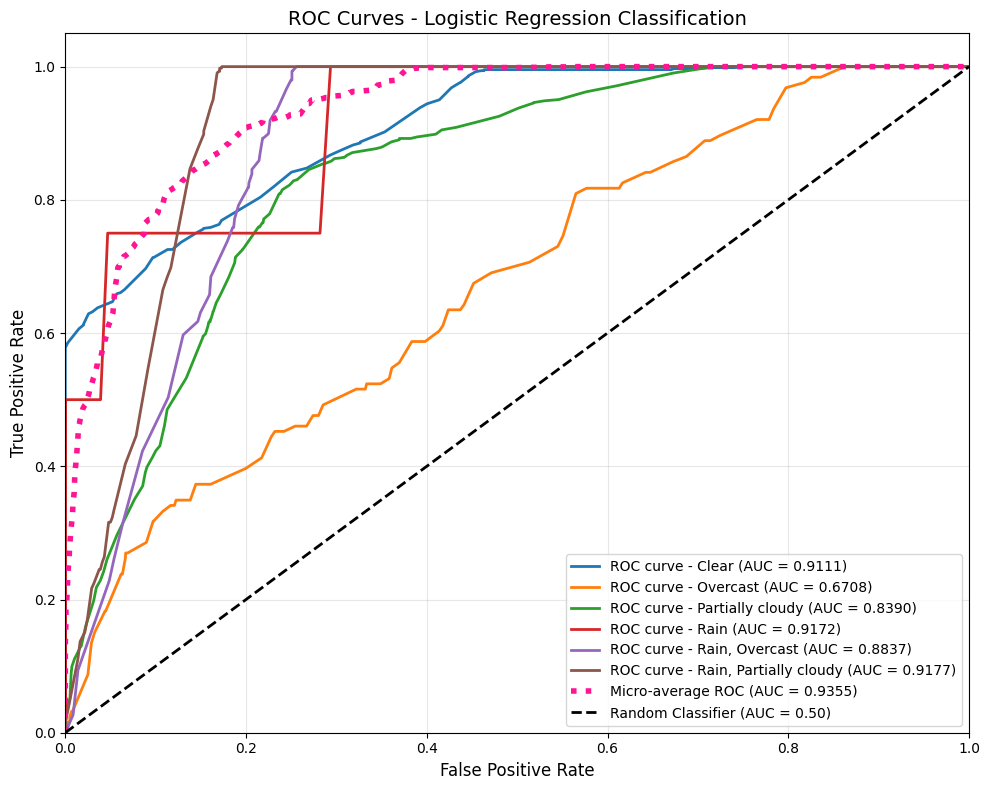

In [170]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [171]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.8619
One-vs-One (Weighted)  : 0.8578
Micro-average          : 0.9355


In [172]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.701436 ≈ 0.701094 (similar)
   F1-Score: 0.676767 ≈ 0.672177 (similar)
   AUC (micro-avg): 0.935829 ≈ 0.935524
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [173]:
grid_search = RandomizedSearchCV(
    BernoulliNB(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=BernoulliNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0, 1.1, 1.2,
                                                  1.3, 1.4, 1.5],
                                        'binarize': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                     0.5]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [174]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
CPU times: total: 703 ms
Wall time: 6.67 s


RandomizedSearchCV(cv=5, estimator=BernoulliNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0, 1.1, 1.2,
                                                  1.3, 1.4, 1.5],
                                        'binarize': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                     0.5]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [175]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'binarize': 0.2, 'alpha': 0.1}
Best Cross-Validation Score: 0.8584600742906072


In [176]:
y_pred_grid = best_grid_model.predict(X_test)

In [177]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [178]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.8953
Precision: 0.8586
Recall:    0.8953
F1-Score:  0.8551


In [179]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.97      0.98      0.97       663
              Overcast       0.00      0.00      0.00       126
      Partially cloudy       0.92      0.99      0.95      1558
                  Rain       1.00      0.75      0.86         4
        Rain, Overcast       0.80      0.03      0.05       149
Rain, Partially cloudy       0.75      1.00      0.85       424

              accuracy                           0.90      2924
             macro avg       0.74      0.62      0.61      2924
          weighted avg       0.86      0.90      0.86      2924



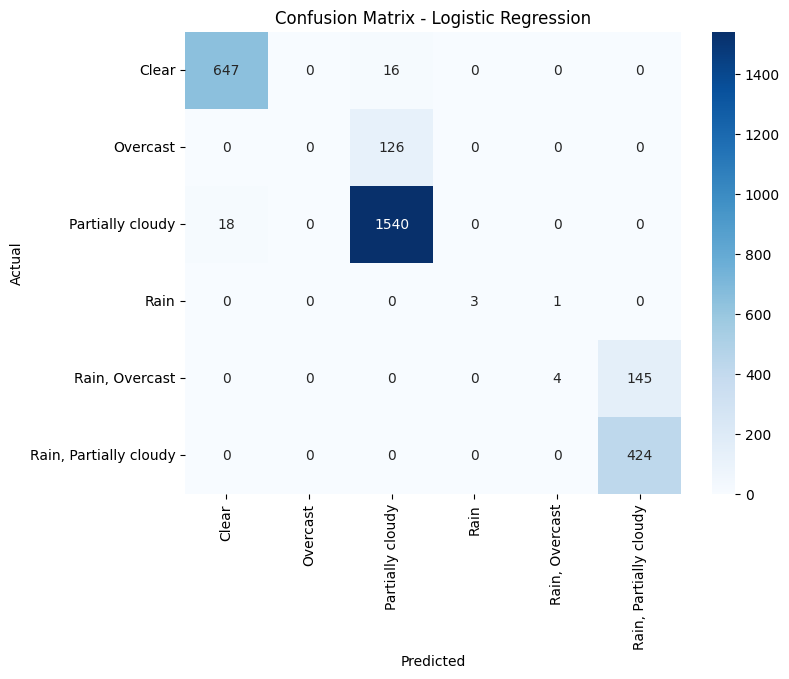

In [180]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [181]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [182]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [183]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9938
Overcast : 0.8274
Partially cloudy : 0.9613
Rain     : 0.9904
Rain, Overcast : 0.9466
Rain, Partially cloudy : 0.9803
Micro-avg : 0.9875


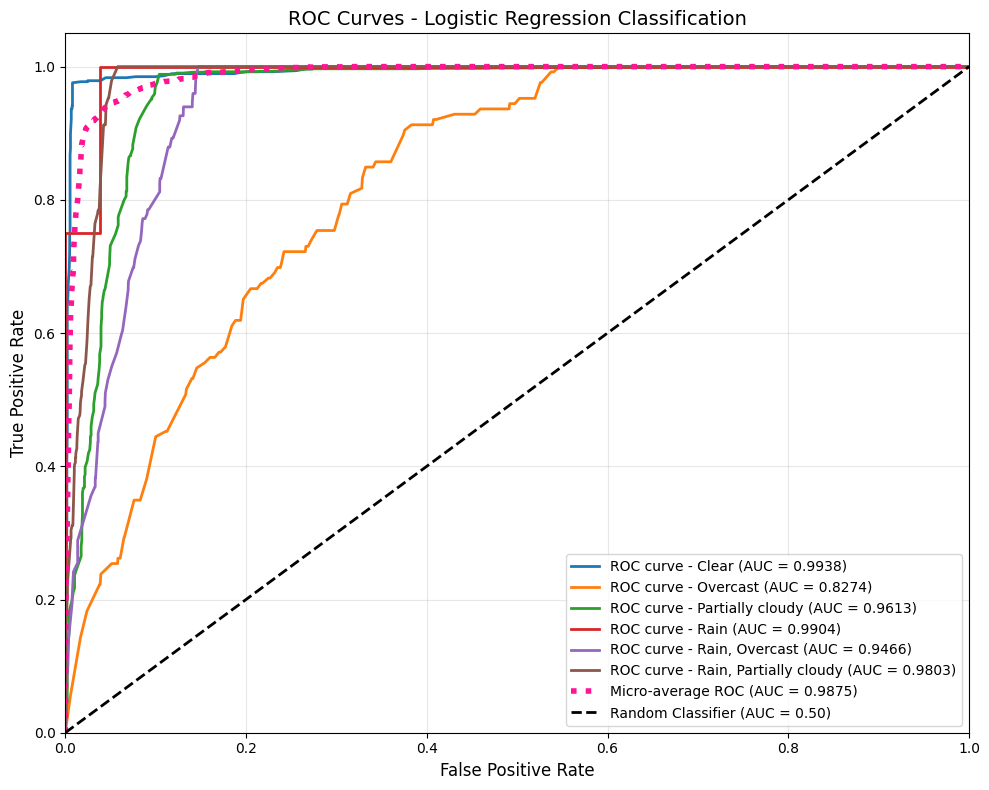

In [184]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [185]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9650
One-vs-One (Weighted)  : 0.9451
Micro-average          : 0.9875


In [186]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.887483 ≈ 0.895349 (similar)
   F1-Score: 0.859298 ≈ 0.855110 (similar)
   AUC (micro-avg): 0.986459 ≈ 0.987509
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [187]:
base_model = BernoulliNB()
base_model

BernoulliNB()

In [188]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=BernoulliNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [189]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


CPU times: total: 31.2 ms
Wall time: 309 ms


BaggingClassifier(bootstrap_features=True, estimator=BernoulliNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [190]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [191]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [192]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.7025
Precision: 0.6704
Recall:    0.7025
F1-Score:  0.6731


In [193]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.76      0.66      0.71       663
              Overcast       0.00      0.00      0.00       126
      Partially cloudy       0.80      0.77      0.78      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.00      0.00      0.00       149
Rain, Partially cloudy       0.49      1.00      0.66       424

              accuracy                           0.70      2924
             macro avg       0.34      0.40      0.36      2924
          weighted avg       0.67      0.70      0.67      2924



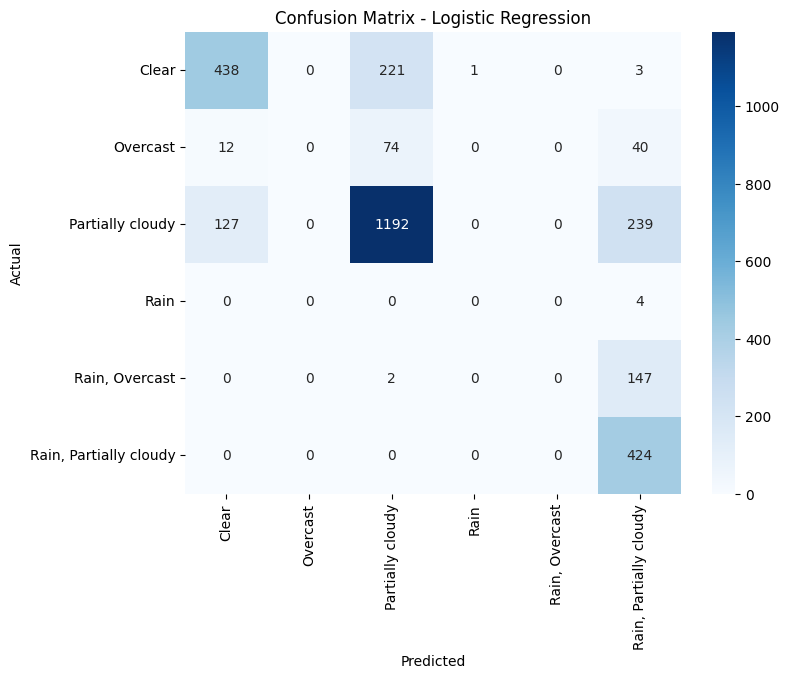

In [194]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [195]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [196]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [197]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9107
Overcast : 0.6821
Partially cloudy : 0.8048
Rain     : 0.8596
Rain, Overcast : 0.8830
Rain, Partially cloudy : 0.9202
Micro-avg : 0.9348


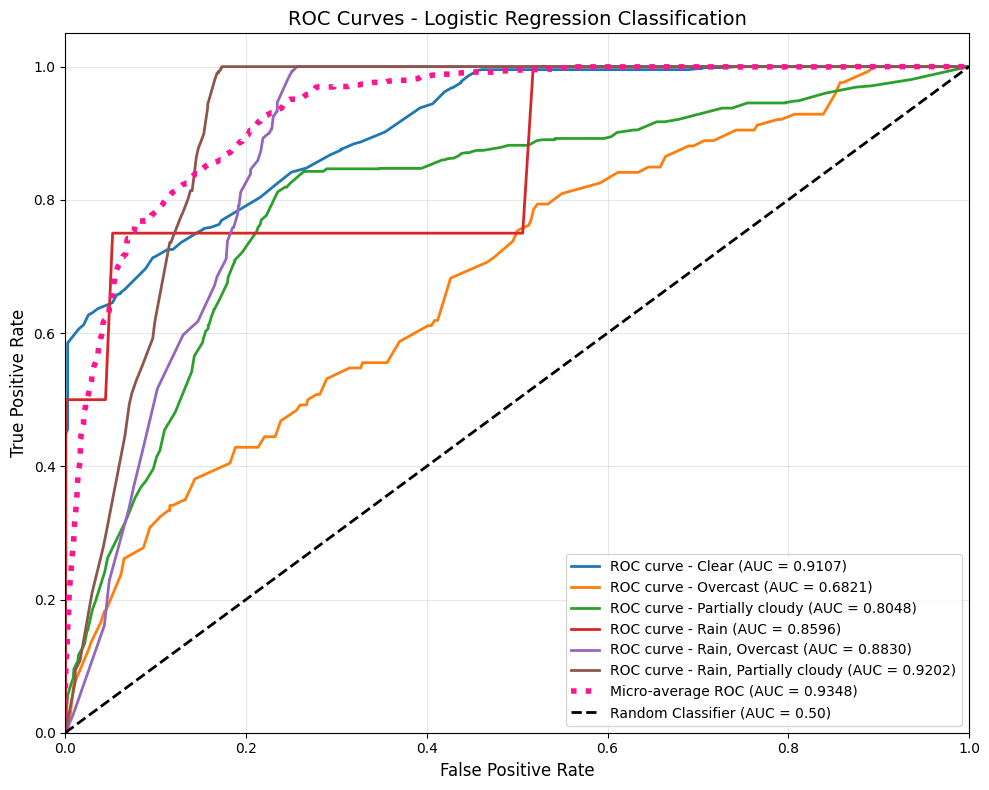

In [198]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [199]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.8443
One-vs-One (Weighted)  : 0.8479
Micro-average          : 0.9348


In [200]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.705882 ≈ 0.702462 (similar)
   F1-Score: 0.676676 ≈ 0.673068 (similar)
   AUC (micro-avg): 0.939757 ≈ 0.934824
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


### Standard Scaler

In [201]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [202]:
X_train

array([[ 1.34459066,  0.64443839,  2.54474033, ..., -0.12811963,
         0.28861286, -0.33504216],
       [-0.53250082,  1.22392493, -0.3929674 , ..., -0.05563671,
        -0.74169989,  3.44763404],
       [ 1.97028782, -1.67350776, -0.3929674 , ..., -0.4982089 ,
        -0.74169989, -0.43437432],
       ...,
       [-0.53250082, -1.67350776, -0.3929674 , ..., -0.86573995,
        -0.74169989, -0.43437432],
       [-0.8453494 , -0.51453468, -0.3929674 , ...,  0.98186394,
        -0.10542524, -0.77398294],
       [-0.8453494 ,  0.49956676,  2.54474033, ...,  0.79539807,
         1.00886284, -0.43437432]], shape=(11692, 23))

In [203]:
X_test

array([[-0.8453494 ,  0.06495186, -0.3929674 , ..., -0.86943516,
         2.16513859, -0.43437432],
       [ 1.03174208,  1.65853984, -0.3929674 , ...,  0.99920299,
        -0.74169989, -0.39074871],
       [ 0.09319634,  0.78931003,  2.54474033, ...,  1.00545642,
        -0.07635686,  2.81338475],
       ...,
       [-0.53250082,  1.0790533 , -0.3929674 , ...,  0.98328517,
        -0.74169989, -0.51021577],
       [ 1.03174208,  1.22392493, -0.3929674 , ...,  0.98584339,
        -0.74169989, -0.30416865],
       [-0.53250082, -0.80427795, -0.3929674 , ..., -0.12954086,
        -0.74169989,  5.41145777]], shape=(2924, 23))

#### Default Parameters

In [204]:
training_model = BernoulliNB()
training_model

BernoulliNB()

In [205]:
%%time
training_model.fit(X_train, y_train)

CPU times: total: 31.2 ms
Wall time: 23.7 ms


BernoulliNB()

In [206]:
y_pred = training_model.predict(X_test)
y_pred

array(['Clear', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      shape=(2924,), dtype='<U22')

In [207]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [208]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [209]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.6683
Precision: 0.7189
Recall:    0.6683
F1-Score:  0.6826


In [210]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.58      0.76      0.65       663
              Overcast       0.24      0.49      0.32       126
      Partially cloudy       0.81      0.64      0.71      1558
                  Rain       0.08      0.50      0.14         4
        Rain, Overcast       0.47      0.52      0.49       149
Rain, Partially cloudy       0.83      0.76      0.79       424

              accuracy                           0.67      2924
             macro avg       0.50      0.61      0.52      2924
          weighted avg       0.72      0.67      0.68      2924



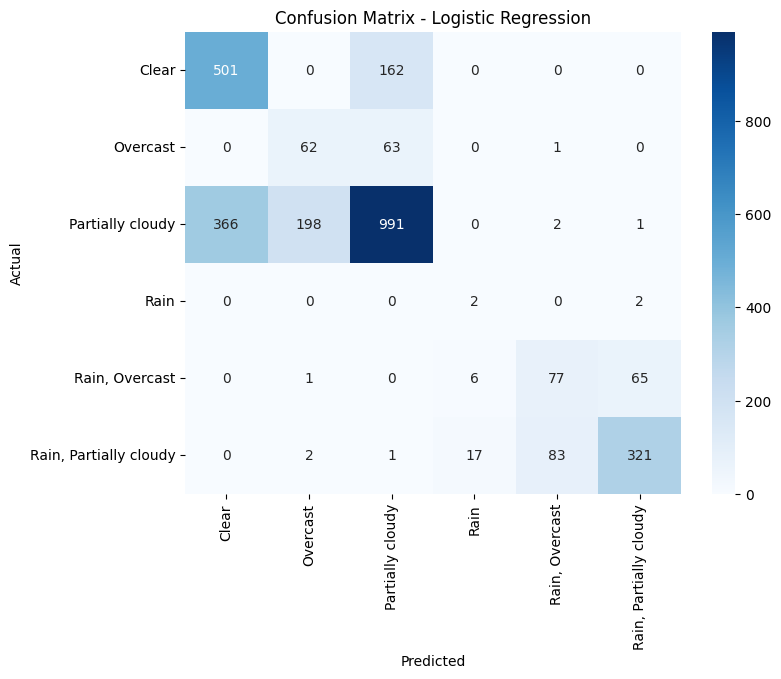

In [211]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [212]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [213]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [214]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.8934
Overcast : 0.9046
Partially cloudy : 0.8476
Rain     : 0.8784
Rain, Overcast : 0.9638
Rain, Partially cloudy : 0.9840
Micro-avg : 0.9477


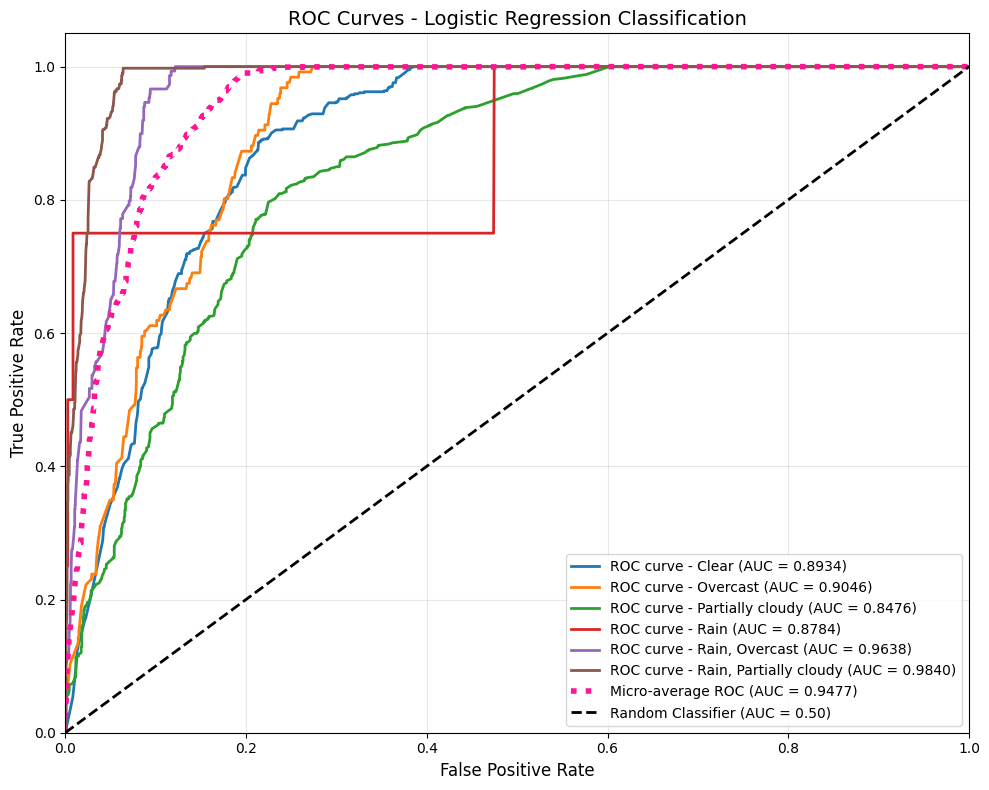

In [215]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [216]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.8862
One-vs-One (Weighted)  : 0.9079
Micro-average          : 0.9477


In [217]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

❌ Classification model not improved:
   Current Accuracy: 0.668263, Best Accuracy: 0.676129
   Current F1: 0.682646, Best F1: 0.690139
   Current AUC (micro-avg): 0.947694, Best AUC: 0.945852
   Current Features: 23, Best Features: 27


#### Tuning with Grid Search

In [218]:
grid_search = RandomizedSearchCV(
    BernoulliNB(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=BernoulliNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0, 1.1, 1.2,
                                                  1.3, 1.4, 1.5],
                                        'binarize': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                     0.5]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [219]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
CPU times: total: 641 ms
Wall time: 6.88 s


RandomizedSearchCV(cv=5, estimator=BernoulliNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0, 1.1, 1.2,
                                                  1.3, 1.4, 1.5],
                                        'binarize': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                     0.5]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [220]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'binarize': 0.3, 'alpha': 0.1}
Best Cross-Validation Score: 0.7004343908858907


In [221]:
y_pred_grid = best_grid_model.predict(X_test)

In [222]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [223]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.6864
Precision: 0.7272
Recall:    0.6864
F1-Score:  0.6966


In [224]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.57      0.77      0.65       663
              Overcast       0.29      0.43      0.35       126
      Partially cloudy       0.82      0.66      0.73      1558
                  Rain       0.15      0.50      0.24         4
        Rain, Overcast       0.48      0.66      0.56       149
Rain, Partially cloudy       0.85      0.73      0.78       424

              accuracy                           0.69      2924
             macro avg       0.53      0.62      0.55      2924
          weighted avg       0.73      0.69      0.70      2924



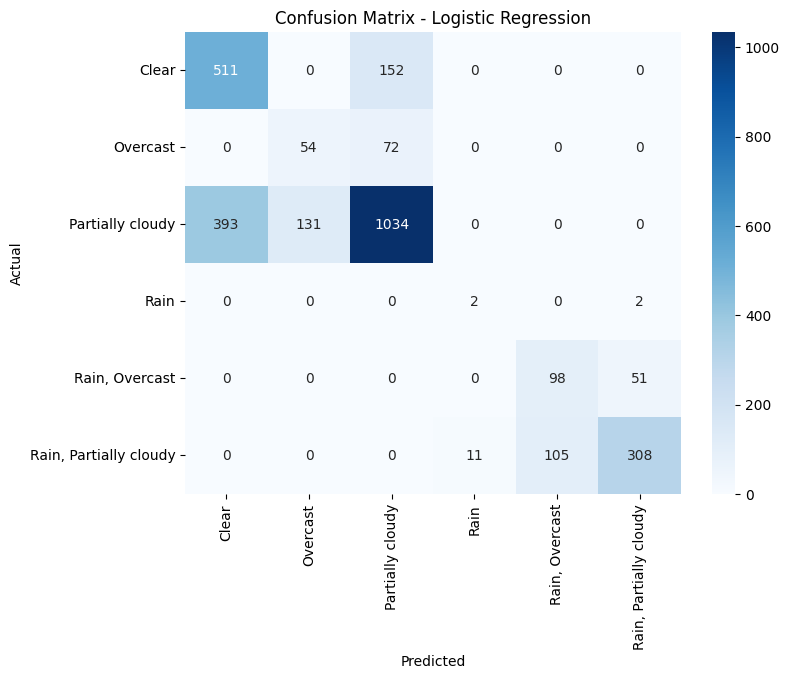

In [225]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [226]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [227]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [228]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.8895
Overcast : 0.9219
Partially cloudy : 0.8509
Rain     : 0.8757
Rain, Overcast : 0.9699
Rain, Partially cloudy : 0.9861
Micro-avg : 0.9507


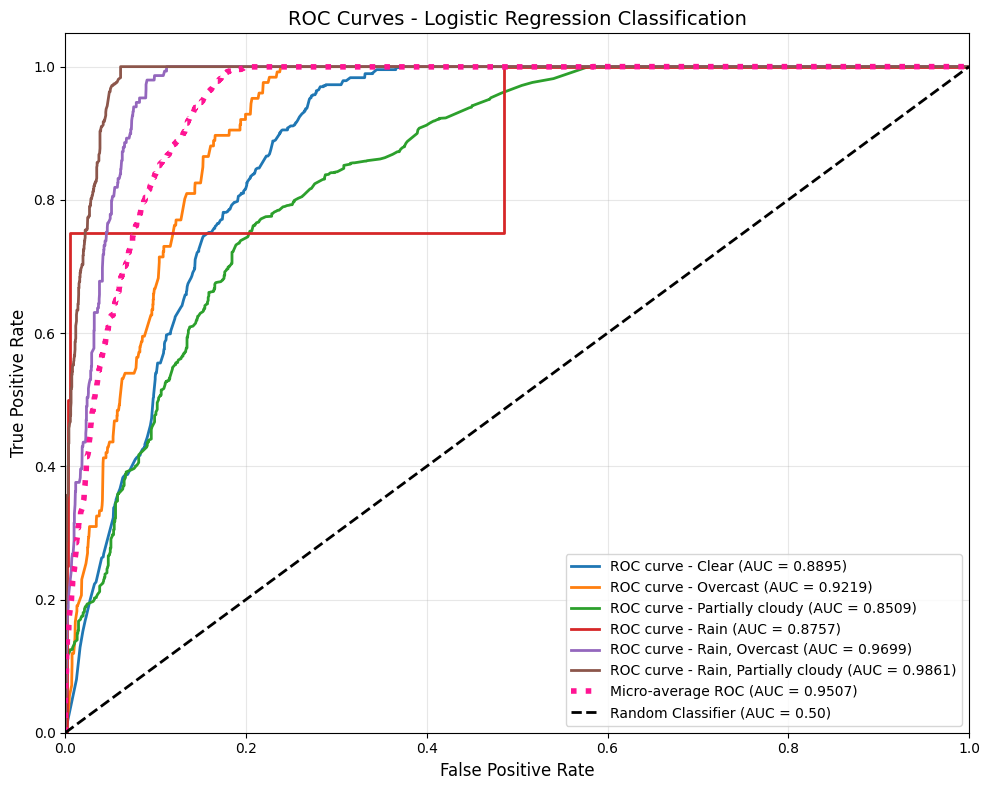

In [229]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [230]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.8884
One-vs-One (Weighted)  : 0.9117
Micro-average          : 0.9507


In [231]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.683995 → 0.686389
   F1-Score: 0.694904 → 0.696630
   AUC (micro-avg): 0.949640 → 0.950652
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [232]:
base_model = BernoulliNB()
base_model

BernoulliNB()

In [233]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=BernoulliNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [234]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s


CPU times: total: 31.2 ms
Wall time: 333 ms


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


BaggingClassifier(bootstrap_features=True, estimator=BernoulliNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [235]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [236]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [237]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.7298
Precision: 0.7298
Recall:    0.7298
F1-Score:  0.7210


In [238]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.59      0.74      0.66       663
              Overcast       0.46      0.10      0.17       126
      Partially cloudy       0.80      0.77      0.79      1558
                  Rain       0.15      0.50      0.24         4
        Rain, Overcast       0.63      0.40      0.49       149
Rain, Partially cloudy       0.80      0.87      0.84       424

              accuracy                           0.73      2924
             macro avg       0.57      0.56      0.53      2924
          weighted avg       0.73      0.73      0.72      2924



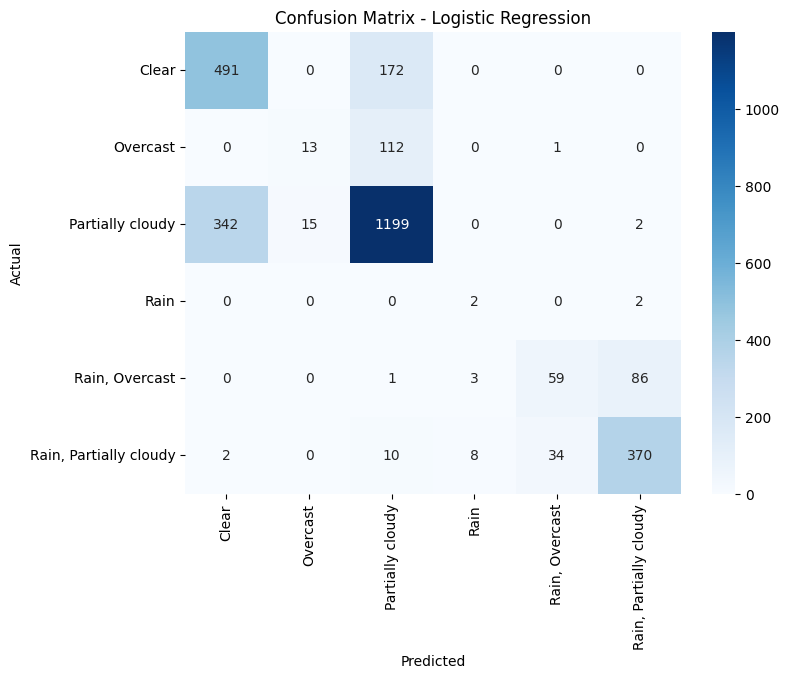

In [239]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [240]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [241]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [242]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.8732
Overcast : 0.8854
Partially cloudy : 0.8196
Rain     : 0.9298
Rain, Overcast : 0.9627
Rain, Partially cloudy : 0.9788
Micro-avg : 0.9387


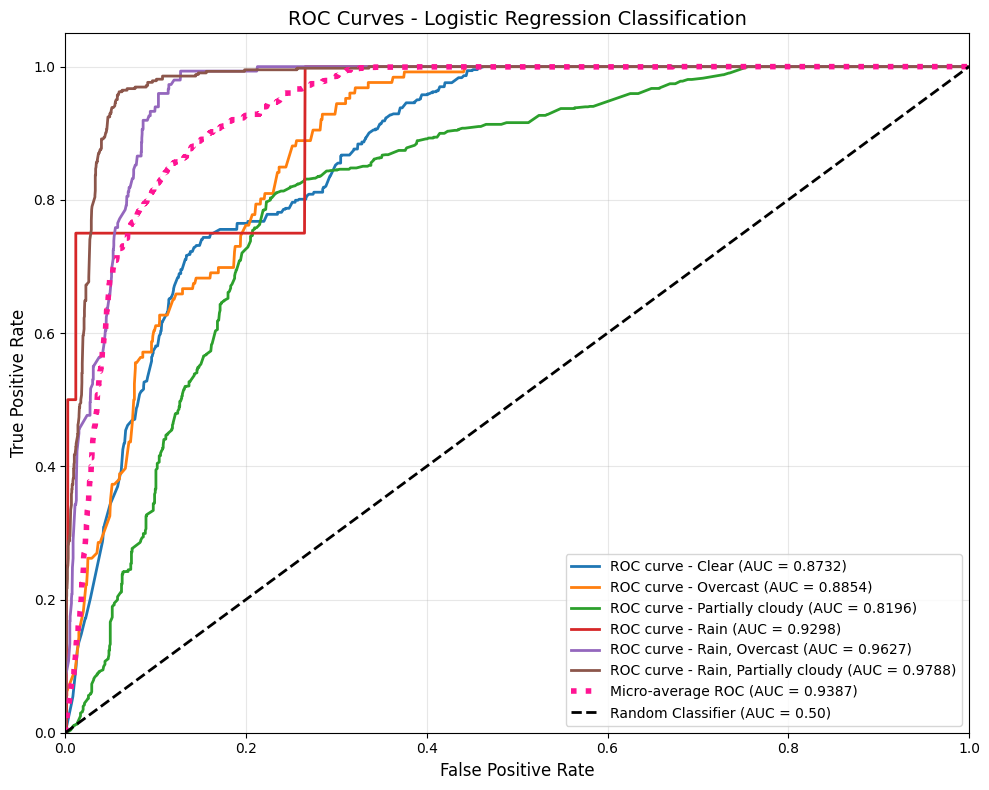

In [243]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [244]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.8651
One-vs-One (Weighted)  : 0.8957
Micro-average          : 0.9387


In [245]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.704514 → 0.729822
   F1-Score: 0.708458 → 0.721021
   AUC (micro-avg): 0.937485 → 0.938659
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


### Robust Scaler

In [246]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [247]:
X_train

array([[ 1.00000000e+00,  3.33333333e-01,  1.00000000e+00, ...,
        -4.07728836e-02,  6.55030801e-01,  5.73643411e-01],
       [-2.00000000e-01,  6.66666667e-01,  0.00000000e+00, ...,
         9.82479122e-04,  0.00000000e+00,  2.24186047e+01],
       [ 1.40000000e+00, -1.00000000e+00,  0.00000000e+00, ...,
        -2.53970853e-01,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.00000000e-01, -1.00000000e+00,  0.00000000e+00, ...,
        -4.65695104e-01,  0.00000000e+00,  0.00000000e+00],
       [-4.00000000e-01, -3.33333333e-01,  0.00000000e+00, ...,
         5.98657279e-01,  4.04517454e-01, -1.96124031e+00],
       [-4.00000000e-01,  2.50000000e-01,  1.00000000e+00, ...,
         4.91239561e-01,  1.11293634e+00,  0.00000000e+00]],
      shape=(11692, 23))

In [248]:
X_test

array([[-0.4       ,  0.        ,  0.        , ..., -0.46782381,
         1.84804928,  0.        ],
       [ 0.8       ,  0.91666667,  0.        , ...,  0.60864582,
         0.        ,  0.25193798],
       [ 0.2       ,  0.41666667,  1.        , ...,  0.61224824,
         0.42299795, 18.75581395],
       ...,
       [-0.2       ,  0.58333333,  0.        , ...,  0.59947601,
         0.        , -0.4379845 ],
       [ 0.8       ,  0.66666667,  0.        , ...,  0.60094973,
         0.        ,  0.75193798],
       [-0.2       , -0.5       ,  0.        , ..., -0.04159162,
         0.        , 33.75968992]], shape=(2924, 23))

#### Default Parameters

In [249]:
training_model = BernoulliNB()
training_model

BernoulliNB()

In [250]:
%%time
training_model.fit(X_train, y_train)

CPU times: total: 31.2 ms
Wall time: 28.3 ms


BernoulliNB()

In [251]:
y_pred = training_model.predict(X_test)
y_pred

array(['Clear', 'Rain, Partially cloudy', 'Rain, Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      shape=(2924,), dtype='<U22')

In [252]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [253]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [254]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.6347
Precision: 0.6643
Recall:    0.6347
F1-Score:  0.6358


In [255]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.59      0.80      0.68       663
              Overcast       0.28      0.18      0.22       126
      Partially cloudy       0.79      0.59      0.68      1558
                  Rain       0.12      0.75      0.21         4
        Rain, Overcast       0.37      0.48      0.42       149
Rain, Partially cloudy       0.55      0.73      0.62       424

              accuracy                           0.63      2924
             macro avg       0.45      0.59      0.47      2924
          weighted avg       0.66      0.63      0.64      2924



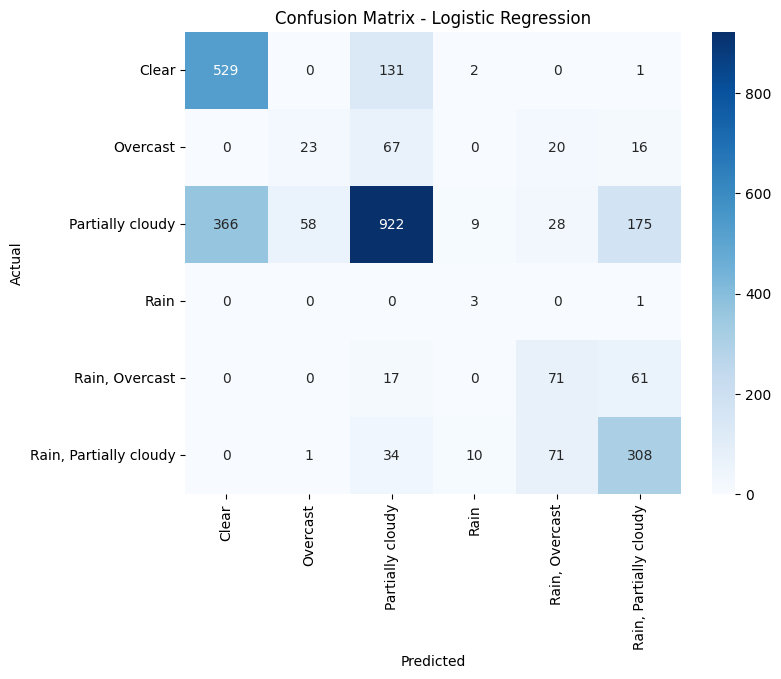

In [256]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [257]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [258]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [259]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9005
Overcast : 0.8480
Partially cloudy : 0.7653
Rain     : 0.9396
Rain, Overcast : 0.9286
Rain, Partially cloudy : 0.9289
Micro-avg : 0.9187


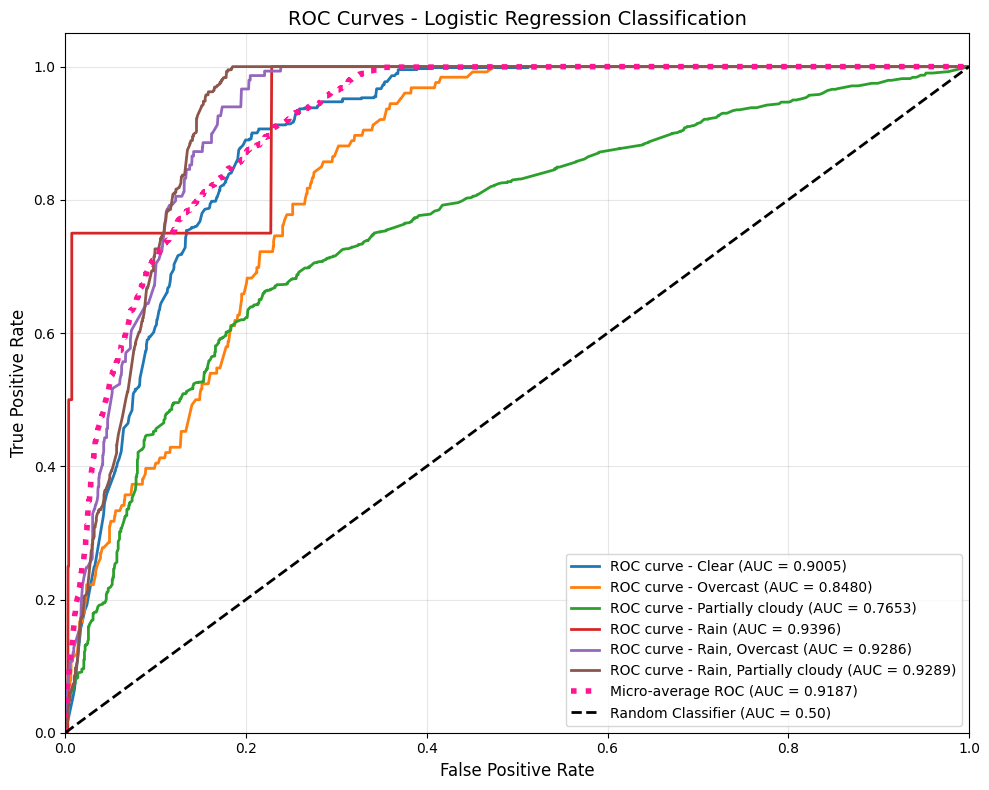

In [260]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [261]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.8318
One-vs-One (Weighted)  : 0.8640
Micro-average          : 0.9187


In [262]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.625855 → 0.634747
   F1-Score: 0.629582 → 0.635774
   AUC (micro-avg): 0.917706 → 0.918668
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [263]:
grid_search = RandomizedSearchCV(
    BernoulliNB(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=BernoulliNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0, 1.1, 1.2,
                                                  1.3, 1.4, 1.5],
                                        'binarize': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                     0.5]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [264]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
CPU times: total: 859 ms
Wall time: 7.34 s


RandomizedSearchCV(cv=5, estimator=BernoulliNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0, 1.1, 1.2,
                                                  1.3, 1.4, 1.5],
                                        'binarize': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                     0.5]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [265]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'binarize': 0.0, 'alpha': 1.2}
Best Cross-Validation Score: 0.6490835515801876


In [266]:
y_pred_grid = best_grid_model.predict(X_test)

In [267]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [268]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.6344
Precision: 0.6646
Recall:    0.6344
F1-Score:  0.6356


In [269]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.59      0.80      0.68       663
              Overcast       0.28      0.18      0.22       126
      Partially cloudy       0.79      0.59      0.68      1558
                  Rain       0.12      0.75      0.20         4
        Rain, Overcast       0.37      0.48      0.42       149
Rain, Partially cloudy       0.55      0.73      0.62       424

              accuracy                           0.63      2924
             macro avg       0.45      0.59      0.47      2924
          weighted avg       0.66      0.63      0.64      2924



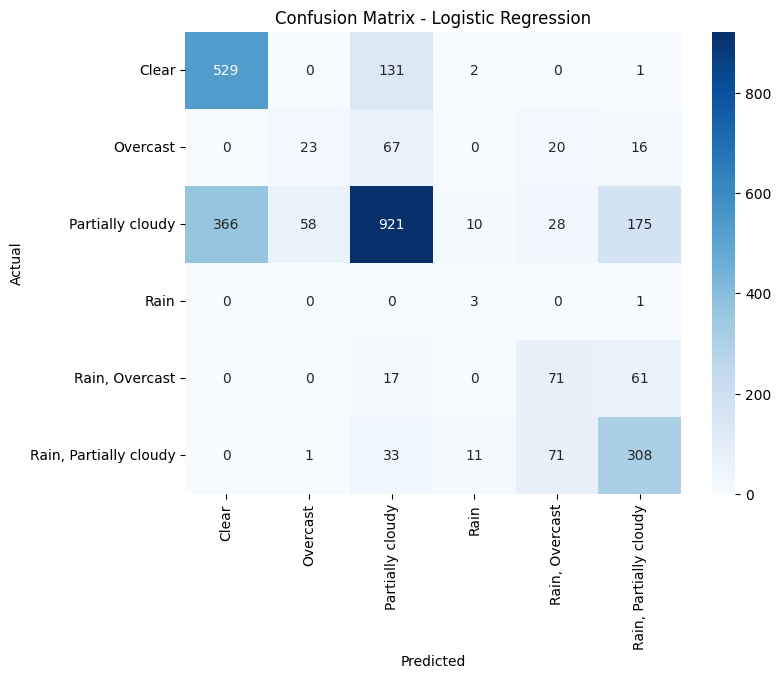

In [270]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [271]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [272]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [273]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.8999
Overcast : 0.8480
Partially cloudy : 0.7652
Rain     : 0.9390
Rain, Overcast : 0.9285
Rain, Partially cloudy : 0.9289
Micro-avg : 0.9184


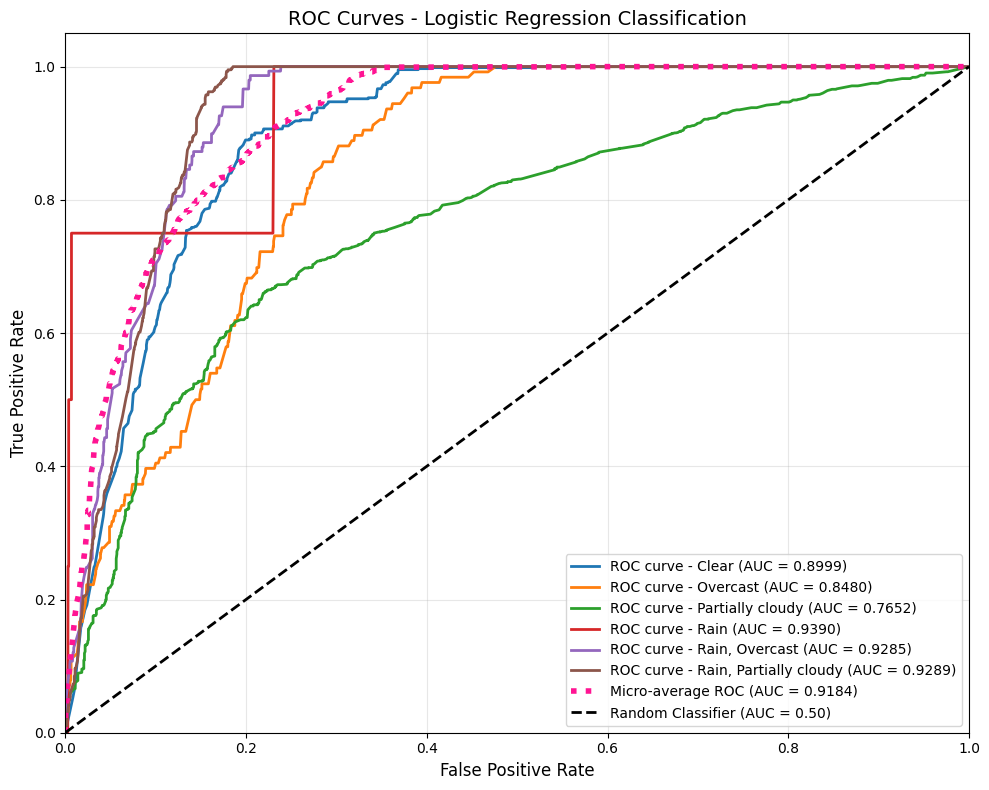

In [274]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [275]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.8316
One-vs-One (Weighted)  : 0.8637
Micro-average          : 0.9184


In [276]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.631669 → 0.634405
   F1-Score: 0.632717 → 0.635628
   AUC (micro-avg): 0.922159 → 0.918396
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [277]:
base_model = BernoulliNB()
base_model

BernoulliNB()

In [278]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=BernoulliNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [279]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


CPU times: total: 46.9 ms
Wall time: 303 ms


BaggingClassifier(bootstrap_features=True, estimator=BernoulliNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [280]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [281]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [282]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.6419
Precision: 0.6494
Recall:    0.6419
F1-Score:  0.6331


In [283]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.59      0.79      0.68       663
              Overcast       0.14      0.01      0.02       126
      Partially cloudy       0.78      0.63      0.69      1558
                  Rain       0.14      0.50      0.22         4
        Rain, Overcast       0.36      0.44      0.39       149
Rain, Partially cloudy       0.54      0.73      0.62       424

              accuracy                           0.64      2924
             macro avg       0.42      0.52      0.44      2924
          weighted avg       0.65      0.64      0.63      2924



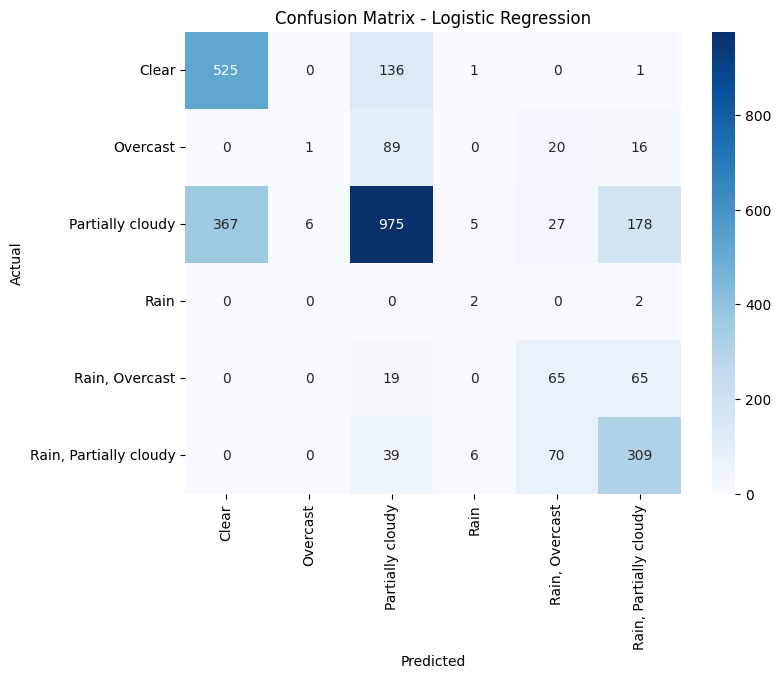

In [284]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [285]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [286]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [287]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.8828
Overcast : 0.8222
Partially cloudy : 0.7628
Rain     : 0.9257
Rain, Overcast : 0.9276
Rain, Partially cloudy : 0.9275
Micro-avg : 0.9107


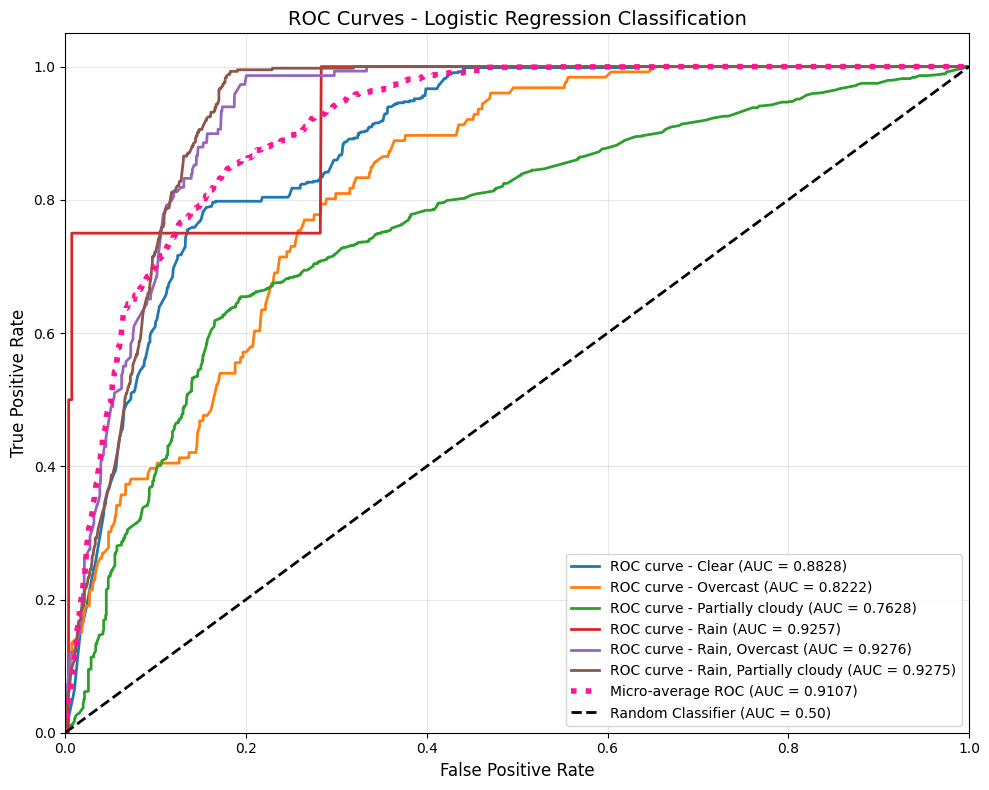

In [288]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [289]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.8251
One-vs-One (Weighted)  : 0.8563
Micro-average          : 0.9107


In [290]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.642955 ≈ 0.641929 (similar)
   F1-Score: 0.638920 ≈ 0.633108 (similar)
   AUC (micro-avg): 0.913445 ≈ 0.910659
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


# All Performance

In [291]:
show_model_history('classification', model_name=model_name_for_saving, target_column=target_name_for_saving)


📊 CLASSIFICATION Model Performance History
                          Model         Scaler     Target  Features Accuracy Precision   Recall F1-Score
   Naive Bayes BernoulliNB Grid   MinMaxScaler Conditions        23 0.895349  0.858643 0.895349 0.855110
Naive Bayes BernoulliNB Bagging StandardScaler Conditions        23 0.729822  0.729789 0.729822 0.721021
   Naive Bayes BernoulliNB Grid StandardScaler Conditions        23 0.686389  0.727233 0.686389 0.696630
        Naive Bayes BernoulliNB StandardScaler Conditions        27 0.676129  0.725797 0.676129 0.690139
Naive Bayes BernoulliNB Bagging   MinMaxScaler Conditions        23 0.702462  0.670415 0.702462 0.673068
        Naive Bayes BernoulliNB   MinMaxScaler Conditions        23 0.701094  0.669432 0.701094 0.672177
        Naive Bayes BernoulliNB   RobustScaler Conditions        23 0.634747  0.664320 0.634747 0.635774
   Naive Bayes BernoulliNB Grid   RobustScaler Conditions        23 0.634405  0.664569 0.634405 0.635628
Naive Bayes

# <center><font size="50" color="red">Thank You</font></center>